In [1]:
import sys
sys.path.append("E:/university/Year 5 Spring/FYT/code/multi_modal_ser")
from utils.const import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio

In [2]:
# Define const path
SPEC_PATH = "E:/datasets/preprocessed/spectrogram"
AST_PATH = os.path.join(SPEC_PATH, "ast")
LIBROSA_PATH = os.path.join(SPEC_PATH, "librosa")
INV_AST_PATH = os.path.join(SPEC_PATH, "inv_ast")
INV_LIBROSA_PATH = os.path.join(SPEC_PATH, "inv_librosa")
RAW_PATH = os.path.join(SPEC_PATH, "raw")

In [3]:
MAX_LEN = 1024
NORM_SPEC = False
HOP_LENGTH = None

### extract audio data

In [4]:
video_rate = 30

from scipy.io import wavfile
import time

spectrogramPATH = 'E:/datasets/preprocessed/spectrogram'
audio_data_list = []

now = time.time()
for ses in range(1, 6):
    extractionmapPATH = 'E:/datasets/preprocessed/extractionmap/cut_extractionmap' + \
        str(ses)+'.xlsx'
    xl = pd.ExcelFile(extractionmapPATH)
    sheets = xl.sheet_names
    spectrogramPATH = spectrogramPATH+'/Session'+str(ses)+'/'
    wavPATH = 'E:/datasets/IEMOCAP_full_release.tar/IEMOCAP_full_release/IEMOCAP_full_release/Session' + \
        str(ses)+'/dialog/wav/'
    for sheet in sheets:
        fileNAME = sheet+'.wav'
        spectrogramPATH = spectrogramPATH+fileNAME+'/'
        audio_rate, data = wavfile.read(wavPATH+fileNAME)
        sheet_df = xl.parse(sheet)
        iframe = np.array(sheet_df['iframe'])
        fframe = np.array(sheet_df['fframe'])
        smp_ids = np.array(sheet_df['smp_id'])
        
        idx = 1
        for idx in range(len(smp_ids)):
            multiframedata = data[iframe[idx]:(fframe[idx]+1)]
            multiframedata = multiframedata.astype('float64').mean(axis=1)
            audio_data_list.append({
                "id": smp_ids[idx],
                "data": multiframedata,
            })
print("Extracting Audios: ", time.time()-now)

Extracting Audios:  13.294363975524902


In [5]:
print(len(audio_data_list))
audio_data_list[0]

10039


{'id': 'Ses01F_impro01_F000',
 'data': array([-130. , -176.5, -263. , ...,  -95.5,  -92.5, -136.5])}

### Define util funcs

In [6]:
# Noticed that the spectrograms here are all before normalization and logged
import librosa
from transformers import ASTFeatureExtractor, ASTModel
from scipy.io.wavfile import write

processor = ASTFeatureExtractor(max_length=MAX_LEN, do_normalize=NORM_SPEC)

def gen_librosa_spec(fn, raw_audio):
    mel = librosa.feature.melspectrogram(y=raw_audio, sr=audio_rate, hop_length=256, n_mels=80)
    mel_spec = np.log(mel)
    np.save(os.path.join(LIBROSA_PATH, fn),mel_spec)
    return mel_spec
    
def gen_ast_spec(fn, raw_audio):
    inputs = processor(raw_audio, sampling_rate=audio_rate, return_tensors="np")
    ast_spec = inputs["input_values"][0].T
    np.save(os.path.join(AST_PATH, fn),ast_spec)
    return ast_spec
    
def save_inv(fn, mel_spec, method=None):
    stft = librosa.feature.inverse.mel_to_stft(np.exp(mel_spec))
    inv_audio = librosa.griffinlim(stft)
    if method is None:
        raise Exception
    inv_save_path = os.path.join(SPEC_PATH, "inv_{}".format(method))
    write(os.path.join(inv_save_path, fn+".wav"), audio_rate, inv_audio.astype("int16"))
    return inv_audio

def save_raw(fn, raw_audio):
    write(os.path.join(RAW_PATH, fn+".wav"), audio_rate, raw_audio.astype("int16"))
    return raw_audio

# AST can be batched?
# AST takes infinite
def process_librosa(data_dict, save_inv_audio=False):
    fn = data_dict["id"]
    raw_audio = data_dict["data"]
    now = time.time()
    raw = save_raw(fn, raw_audio)
    print("Save Raw:", time.time() - now)
    now = time.time()
    
    librosa_spec = gen_librosa_spec(fn, raw_audio)
    print("Gen Spec:", time.time() - now)
    now = time.time()
    if save_inv_audio:
        inv_librosa = save_inv(fn, librosa_spec, "librosa")
        print("Save Inv:", time.time() - now)
        now = time.time()
        return raw, inv_librosa, librosa_spec
    else:
        return raw, librosa_spec

In [7]:
raw, inv_librosa, librosa_spec = process_librosa(audio_data_list[0], save_inv_audio=True)

Save Raw: 0.0009918212890625
Gen Spec: 2.7107479572296143
Save Inv: 1.4796922206878662


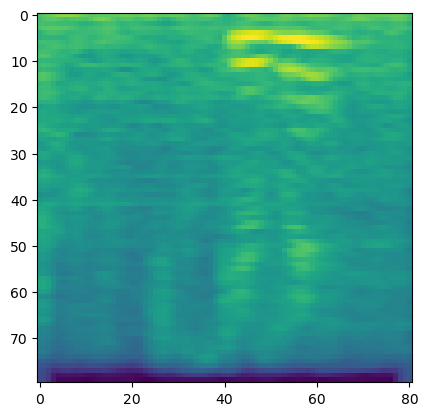

In [8]:
plt.imshow(librosa_spec)

In [9]:
Audio(raw, rate=audio_rate)

In [10]:
Audio(inv_librosa, rate=audio_rate)

### Pool librosa

The inversion takes much longer than generating the spectrogram

In [11]:
for audio_data in audio_data_list:
    process_librosa(audio_data)

Save Raw: 0.0
Gen Spec: 0.005998849868774414
Save Raw: 0.0
Gen Spec: 0.007998466491699219
Save Raw: 0.0010001659393310547
Gen Spec: 0.003999471664428711
Save Raw: 0.0010008811950683594
Gen Spec: 0.010998964309692383
Save Raw: 0.0
Gen Spec: 0.00899958610534668
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.009000301361083984
Save Raw: 0.0
Gen Spec: 0.009000301361083984
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.004999399185180664
Save Raw: 0.0010013580322265625
Gen Spec: 0.02199840545654297
Save Raw: 0.0
Gen Spec: 0.006001710891723633
Save Raw: 0.0
Gen Spec: 0.00999903678894043
Save Raw: 0.0009999275207519531
Gen Spec: 0.013000011444091797
Save Raw: 0.0010001659393310547
Gen Spec: 0.011000633239746094
Save Raw: 0.0010001659393310547
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.009999752044677734
Save Raw: 0.0
Gen Spec: 0.009998798370361328
Save Raw: 0.0010004043579101562
Gen Spe

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
C:\Users\LEGION\AppData\Local\Temp\ipykernel_21304\875180783.py:10: RuntimeWarning: divide by zero encountered in log
  mel_spec = np.log(mel)


Gen Spec: 0.006000995635986328
Save Raw: 0.0010004043579101562
Gen Spec: 0.013998270034790039
Save Raw: 0.0010018348693847656
Gen Spec: 0.0049991607666015625
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0009996891021728516
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.00400233268737793
Save Raw: 0.0
Gen Spec: 0.0029985904693603516
Save Raw: 0.0010006427764892578
Gen Spec: 0.023999691009521484
Save Raw: 0.0009992122650146484
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.005001068115234375
Save Raw: 0.00099945068359375
Gen Spec: 0.014000415802001953
Save Raw: 0.0009984970092773438
Gen Spec: 0.016001462936401367
Save Raw: 0.0009992122650146484
Gen Spec: 0.013998985290527344
Save Raw: 0.0
Gen Spec: 0.015000104904174805
Save Raw: 0.0009999275207519531
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.0070002079010009766
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.0109992027282714

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1042
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=322
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=802
  warnings.warn(


Gen Spec: 0.00834512710571289
Save Raw: 0.0009982585906982422
Gen Spec: 0.003000974655151367
Save Raw: 0.0
Gen Spec: 0.007998943328857422
Save Raw: 0.001001119613647461
Gen Spec: 0.008999824523925781
Save Raw: 0.0010001659393310547
Gen Spec: 0.003038167953491211
Save Raw: 0.0
Gen Spec: 0.01385045051574707
Save Raw: 0.0010006427764892578
Gen Spec: 0.0029997825622558594
Save Raw: 0.0
Gen Spec: 0.0059986114501953125
Save Raw: 0.0
Gen Spec: 0.004014492034912109
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0040073394775390625
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.003997802734375
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.011998891830444336
Save Raw: 0.0039997100830078125
Gen Spec: 0.004002571105957031
Save Raw: 0.0
Gen Spec: 0.003996372222900391
Save Raw: 0.0
Gen

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=922
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=642
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1678
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=162
  warnings.warn(


Save Raw: 0.004000663757324219
Gen Spec: 0.01017451286315918
Save Raw: 0.0009992122650146484
Gen Spec: 0.01804804801940918
Save Raw: 0.0
Gen Spec: 0.003997325897216797
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.009226560592651367
Save Raw: 0.0
Gen Spec: 0.008998394012451172
Save Raw: 0.0
Gen Spec: 0.0019989013671875
Save Raw: 0.0009992122650146484
Gen Spec: 0.0060002803802490234
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0010004043579101562
Gen Spec: 0.010999917984008789
Save Raw: 0.0
Gen Spec: 0.0040035247802734375
Save Raw: 0.0009958744049072266
Gen Spec: 0.013000726699829102
Save Raw: 0.0
Gen Spec: 0.006000518798828125
Save Raw: 0.0
Gen Spec: 0.005999326705932617
Save Raw: 0.0009996891021728516
Gen Spec: 0.009001016616821289
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.0010046958923339844
Gen Spec: 0.00399470329284668
Save Raw: 0.0009999275207519531
Gen Spec: 0.015000343322753906
Save Raw: 0.0009999275207519531
Gen Spec: 0.0099995

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=482
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1442
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=801
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1922
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1162
  warnings.warn(


Gen Spec: 0.006297111511230469
Save Raw: 0.0009992122650146484
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0
Gen Spec: 0.0029993057250976562
Save Raw: 0.0009996891021728516
Gen Spec: 0.009041070938110352
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.004000186920166016
Gen Spec: 0.021738767623901367
Save Raw: 0.0009968280792236328
Gen Spec: 0.01004481315612793
Save Raw: 0.0
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.019999980926513672
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.008014917373657227
Save Raw: 0.0
Gen Spec: 0.003985404968261719
Save Raw: 0.0
Gen Spec: 0.004002809524536133
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003999233245849609
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1682
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1322
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1642
  warnings.warn(


Gen Spec: 0.012077808380126953
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.003007173538208008
Save Raw: 0.0009927749633789062
Gen Spec: 0.00599980354309082
Save Raw: 0.0010402202606201172
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0040035247802734375
Gen Spec: 0.0039980411529541016
Save Raw: 0.0
Gen Spec: 0.013809680938720703
Save Raw: 0.0
Gen Spec: 0.011036157608032227
Save Raw: 0.0
Gen Spec: 0.016000747680664062
Save Raw: 0.0
Gen Spec: 0.01200246810913086
Save Raw: 0.003998756408691406
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.003999948501586914
Gen Spec: 0.011999845504760742

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1898
  warnings.warn(


Gen Spec: 0.035707712173461914
Save Raw: 0.0
Gen Spec: 0.010845422744750977
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0009996891021728516
Gen Spec: 0.009001016616821289
Save Raw: 0.0010960102081298828
Gen Spec: 0.01406717300415039
Save Raw: 0.0010097026824951172
Gen Spec: 0.0439906120300293
Save Raw: 0.0010004043579101562
Gen Spec: 0.003000020980834961
Save Raw: 0.0009992122650146484
Gen Spec: 0.007999897003173828
Save Raw: 0.0010004043579101562
Gen Spec: 0.020999670028686523
Save Raw: 0.0010001659393310547
Gen Spec: 0.015000581741333008
Save Raw: 0.002000570297241211
Gen Spec: 0.05099964141845703
Save Raw: 0.0009999275207519531
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010006427764892578
Gen Spec: 0.003000497817993164
Save Raw: 0.0009992122650146484
Gen Spec: 0.0069997310638427734
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.0069997310638427734
Save Raw: 0.0009992122650146484
Gen Spec: 0.006999969482421875
Save Raw: 0.0
Gen Spec: 0.00500082

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=722
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(


Gen Spec: 0.0069997310638427734
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.0009999275207519531
Gen Spec: 0.010000228881835938
Save Raw: 0.0009999275207519531
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.0009996891021728516
Gen Spec: 0.009000301361083984
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.0
Gen Spec: 0.0069997310638427734
Save Raw: 0.0009989738464355469
Gen Spec: 0.022001266479492188
Save Raw: 0.0010001659393310547
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0010006427764892578
Gen Spec: 0.01199960708618164
Save Raw: 0.0010001659393310547
Gen Spec: 0.007002592086791992
Save Raw: 0.0
Gen Spec: 0.009764432907104492
Save Raw: 0.0009996891021728516
Gen Spec: 0.013999700546264648
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0009980201721191406
Gen Spec: 0.017000198364257812
Save Raw: 0.0
Gen Spec: 0.006001472473144531
Save Raw: 0.0
Gen Spec: 0.017997503280639

Gen Spec: 0.00879359245300293
Save Raw: 0.0
Gen Spec: 0.012998342514038086
Save Raw: 0.0009996891021728516
Gen Spec: 0.004999876022338867
Save Raw: 0.0010006427764892578
Gen Spec: 0.0030612945556640625
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.016002178192138672
Save Raw: 0.0
Gen Spec: 0.015997886657714844
Save Raw: 0.0
Gen Spec: 0.012001514434814453
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.01599907875061035
Save Raw: 0.0
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.015999555587768555
Save Raw: 0.00400090217590332
Gen Spec: 0.015999794006347656
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.017882108688354492
Save Raw: 0.0
Gen Spec

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=962
  warnings.warn(


Gen Spec: 0.015889644622802734
Save Raw: 0.0005211830139160156
Gen Spec: 0.009991168975830078
Save Raw: 0.0009999275207519531
Gen Spec: 0.0019996166229248047
Save Raw: 0.001001119613647461
Gen Spec: 0.018123149871826172
Save Raw: 0.0
Gen Spec: 0.01599740982055664
Save Raw: 0.0
Gen Spec: 0.015999317169189453
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.01600027084350586
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.016001224517822266
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.004002094268798828
Save Raw: 0.0
Gen Spec: 0.0039980411529541016
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.01999974250793457
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0040

Gen Spec: 0.013220787048339844
Save Raw: 0.0009999275207519531
Gen Spec: 0.004999399185180664
Save Raw: 0.0010001659393310547
Gen Spec: 0.008999824523925781
Save Raw: 0.0009999275207519531
Gen Spec: 0.013004541397094727
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.015999794006347656
Save Raw: 0.003999948501586914
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.0279998779296875
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.012001276016235352
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.02799844741821289
Save Raw: 0.004000425338745117
Gen Spec: 0.01199960708618164
Save Raw: 0.004000186920166016
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003999471664428711

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1001
  warnings.warn(


Gen Spec: 0.012000083923339844
Save Raw: 0.0021042823791503906
Gen Spec: 0.011992692947387695
Save Raw: 0.0020008087158203125
Gen Spec: 0.009040117263793945
Save Raw: 0.0
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.001962900161743164
Gen Spec: 0.016991376876831055
Save Raw: 0.0
Gen Spec: 0.003066539764404297
Save Raw: 0.0
Gen Spec: 0.008006572723388672
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.004000186920166016
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.01037287712097168
Save Raw: 0.0
Gen Spec: 0.007992029190063477
Save Raw: 0.0040471553802490234
Gen Spec: 0.003994941711425781
Save Raw: 0.0
Gen Spec: 0.00

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


Gen Spec: 0.010953664779663086
Save Raw: 0.0010018348693847656
Gen Spec: 0.004998683929443359
Save Raw: 0.00099945068359375
Gen Spec: 0.002000093460083008
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0
Gen Spec: 0.002000093460083008
Save Raw: 0.0
Gen Spec: 0.0031032562255859375
Save Raw: 0.0020198822021484375
Gen Spec: 0.00399327278137207
Save Raw: 0.003999471664428711
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.003999948501586914
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0018725395202636719
Gen Spec: 0.005991935729980469
Save Raw: 0.0009996891021728516
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.005000591278076172
Save Raw: 0.00099945068359375
Gen Spec: 0.01604747772216797
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003998279571533203
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0039994716644287

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1161
  warnings.warn(


Gen Spec: 0.010998725891113281
Save Raw: 0.0010216236114501953
Gen Spec: 0.008978843688964844
Save Raw: 0.0009989738464355469
Gen Spec: 0.0050013065338134766
Save Raw: 0.0009987354278564453
Gen Spec: 0.004000186920166016
Save Raw: 0.0010004043579101562
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.008983135223388672
Save Raw: 0.0009999275207519531
Gen Spec: 0.0070002079010009766
Save Raw: 0.00099945068359375
Gen Spec: 0.0039997100830078125
Save Raw: 0.0010001659393310547
Gen Spec: 0.010933160781860352
Save Raw: 0.0
Gen Spec: 0.006015300750732422
Save Raw: 0.0
Gen Spec: 0.004984140396118164
Save Raw: 0.0010008811950683594
Gen Spec: 0.007085084915161133
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.003999948501586914
Gen Spec: 0.00800013542175293
Save Raw: 0.004001140594482422
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.008132219314575195
Save Raw: 0.0
Gen Spec: 0.007990360260009766
Save Raw: 0.0
Gen Spec: 0.0021991729736328125
Save Raw: 0.0
Gen Spec: 0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2041
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1122
  warnings.warn(


Gen Spec: 0.003999233245849609
Save Raw: 0.002427339553833008
Gen Spec: 0.0019989013671875
Save Raw: 0.0010006427764892578
Gen Spec: 0.0019981861114501953
Save Raw: 0.0010001659393310547
Gen Spec: 0.00599980354309082
Save Raw: 0.0
Gen Spec: 0.0020034313201904297
Save Raw: 0.0010106563568115234
Gen Spec: 0.00798654556274414
Save Raw: 0.0
Gen Spec: 0.0020036697387695312
Save Raw: 0.0
Gen Spec: 0.0040073394775390625
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.012002229690551758
Save Raw: 0.0
Gen Spec: 0.0039975643157958984
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003998994827270508
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1602
  warnings.warn(


Gen Spec: 0.003995418548583984
Save Raw: 0.0009999275207519531
Gen Spec: 0.008000373840332031
Save Raw: 0.0010123252868652344
Gen Spec: 0.007986068725585938
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.0009996891021728516
Gen Spec: 0.013000965118408203
Save Raw: 0.0010006427764892578
Gen Spec: 0.009000301361083984
Save Raw: 0.00099945068359375
Gen Spec: 0.01299905776977539
Save Raw: 0.0010004043579101562
Gen Spec: 0.011001110076904297
Save Raw: 0.0009984970092773438
Gen Spec: 0.011000871658325195
Save Raw: 0.0
Gen Spec: 0.00500035285949707
Save Raw: 0.0009989738464355469
Gen Spec: 0.00899958610534668
Save Raw: 0.0010027885437011719
Gen Spec: 0.031998395919799805
Save Raw: 0.00099945068359375
Gen Spec: 0.00700068473815918
Save Raw: 0.0
Gen Spec: 0.00899958610534668
Save Raw: 0.0009992122650146484
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.005002021789550781
Save Raw: 0.0009987354278564453
Gen Spec: 0.009000301361083984
Save Raw: 0.0
Gen Spec: 0.0070016384124755

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1282
  warnings.warn(


Gen Spec: 0.009997844696044922
Save Raw: 0.0
Gen Spec: 0.005000591278076172
Save Raw: 0.0009989738464355469
Gen Spec: 0.007002115249633789
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0009992122650146484
Gen Spec: 0.005000591278076172
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.0
Gen Spec: 0.009000062942504883
Save Raw: 0.0009996891021728516
Gen Spec: 0.011002302169799805
Save Raw: 0.0009989738464355469
Gen Spec: 0.006999492645263672
Save Raw: 0.0010008811950683594
Gen Spec: 0.011999368667602539
Save Raw: 0.0010209083557128906
Gen Spec: 0.0029778480529785156
Save Raw: 0.0010001659393310547
Gen Spec: 0.013000965118408203
Save Raw: 0.00099945068359375
Gen Spec: 0.013000249862670898
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0010006427764892578
Gen Spec: 0.013000249862670898
Save Raw: 0.0010004043579101562
Gen Spec: 0.0040204524993896484
Save Raw: 0.000978708267211914
Gen Spec: 0.001999378204345703
Save Ra

Gen Spec: 0.014603137969970703
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0010006427764892578
Gen Spec: 0.006998777389526367
Save Raw: 0.0010421276092529297
Gen Spec: 0.008001089096069336
Save Raw: 0.004000186920166016
Gen Spec: 0.011999368667602539
Save Raw: 0.0007982254028320312
Gen Spec: 0.018088579177856445
Save Raw: 0.0
Gen Spec: 0.017233848571777344
Save Raw: 0.0009996891021728516
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010001659393310547
Gen Spec: 0.000804901123046875
Save Raw: 0.003991842269897461
Gen Spec: 0.006442546844482422
Save Raw: 0.0
Gen Spec: 0.006990194320678711
Save Raw: 0.0010004043579101562
Gen Spec: 0.01009058952331543
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.0
Gen Spec: 0.019021987915039062
Save Raw: 0.0
Gen Spec: 0.003992319107055664
Save Raw: 0.0
Gen Spec: 0.020000934600830078
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.02400064468383789
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.0
Gen 

Gen Spec: 0.0279996395111084
Save Raw: 0.00099945068359375
Gen Spec: 0.020512104034423828
Save Raw: 0.0009999275207519531
Gen Spec: 0.0349733829498291
Save Raw: 0.0010004043579101562
Gen Spec: 0.023998022079467773
Save Raw: 0.0009996891021728516
Gen Spec: 0.0050008296966552734
Save Raw: 0.0009992122650146484
Gen Spec: 0.005125761032104492
Save Raw: 0.0010001659393310547
Gen Spec: 0.03899717330932617
Save Raw: 0.0009999275207519531
Gen Spec: 0.016001224517822266
Save Raw: 0.0
Gen Spec: 0.005094766616821289
Save Raw: 0.0
Gen Spec: 0.003917694091796875
Save Raw: 0.0
Gen Spec: 0.004988193511962891
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0009989738464355469
Gen Spec: 0.015000343322753906
Save Raw: 0.0010001659393310547
Gen Spec: 0.016034603118896484
Save Raw: 0.0010001659393310547
Gen Spec: 0.023092985153198242
Save Raw: 0.0
Gen Spec: 0.004171133041381836
Save Raw: 0.003968954086303711
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.009949922561645508
Save Raw: 0.0

Gen Spec: 0.006000041961669922
Save Raw: 0.0009996891021728516
Gen Spec: 0.010999441146850586
Save Raw: 0.0
Gen Spec: 0.008999824523925781
Save Raw: 0.0
Gen Spec: 0.008999824523925781
Save Raw: 0.0
Gen Spec: 0.009000539779663086
Save Raw: 0.0
Gen Spec: 0.006999969482421875
Save Raw: 0.001001119613647461
Gen Spec: 0.01099848747253418
Save Raw: 0.0009996891021728516
Gen Spec: 0.006999969482421875
Save Raw: 0.0
Gen Spec: 0.02200484275817871
Save Raw: 0.0009963512420654297
Gen Spec: 0.0059986114501953125
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0010001659393310547
Gen Spec: 0.0030002593994140625
Save Raw: 0.0009989738464355469
Gen Spec: 0.031002044677734375
Save Raw: 0.0010106563568115234
Gen Spec: 0.004987955093383789
Save Raw: 0.0009999275207519531
Gen Spec: 0.008000612258911133
Save Raw: 0.00099945068359375
Gen Spec: 0.00700068473815918
Save Raw: 0.0009999275207519531
Gen Spec: 0.009000062942504883
Save Raw: 0.0010004043579101562
Gen Spec: 0.022999286651611328
Save Raw: 

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1424
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=324
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=299
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=648
  warnings.warn(


Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0009999275207519531
Gen Spec: 0.01799917221069336
Save Raw: 0.0010013580322265625
Gen Spec: 0.005000591278076172
Save Raw: 0.0009980201721191406
Gen Spec: 0.0030002593994140625
Save Raw: 0.001001119613647461
Gen Spec: 0.0029993057250976562
Save Raw: 0.0009999275207519531
Gen Spec: 0.015999317169189453
Save Raw: 0.0
Gen Spec: 0.018000364303588867
Save Raw: 0.0010001659393310547
Gen Spec: 0.0110015869140625
Save Raw: 0.0009992122650146484
Gen Spec: 0.017000436782836914
Save Raw: 0.0
Gen Spec: 0.010999679565429688
Save Raw: 0.0010006427764892578
Gen Spec: 0.025998353958129883
Save Raw: 0.0010004043579101562
Gen Spec: 0.0019991397857666016
Save Raw: 0.0010001659393310547
Gen Spec: 0.011000633239746094
Save Raw: 0.00099945068359375
Gen Spec: 0.010999679565429688
Save Raw: 0.0009996891021728516
Gen Spec: 0.011000394821166992
Save Raw: 0.0010006427764892578
Gen Spec: 0.01399993896484375
Save Raw: 0.0
Gen 

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1273
  warnings.warn(


Gen Spec: 0.023001909255981445
Save Raw: 0.0009989738464355469
Gen Spec: 0.005999565124511719
Save Raw: 0.0009996891021728516
Gen Spec: 0.029001235961914062
Save Raw: 0.0009999275207519531
Gen Spec: 0.024999618530273438
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.0020003318786621094
Save Raw: 0.00099945068359375
Gen Spec: 0.01800060272216797
Save Raw: 0.0
Gen Spec: 0.017998695373535156
Save Raw: 0.001001119613647461
Gen Spec: 0.025999784469604492
Save Raw: 0.0
Gen Spec: 0.014999866485595703
Save Raw: 0.0009999275207519531
Gen Spec: 0.023000717163085938
Save Raw: 0.001001119613647461
Gen Spec: 0.028998136520385742
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0010006427764892578
Gen Spec: 0.010000467300415039
Save Raw: 0.0019991397857666016
Gen Spec: 0.012999534606933594
Save Raw: 0.0
Gen Spec: 0.020000696182250977
Save Raw: 0.0010123252868652344
Gen Spec: 0.02798938751220703
Save Raw: 0.0010004043579101562
Gen Spec: 0.023012399673461914
Save Raw: 0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=310
  warnings.warn(


Gen Spec: 0.014000654220581055
Save Raw: 0.0009999275207519531
Gen Spec: 0.012001514434814453
Save Raw: 0.0009989738464355469
Gen Spec: 0.003000497817993164
Save Raw: 0.0010001659393310547
Gen Spec: 0.009999752044677734
Save Raw: 0.0
Gen Spec: 0.026999235153198242
Save Raw: 0.0010027885437011719
Gen Spec: 0.003996372222900391
Save Raw: 0.0010001659393310547
Gen Spec: 0.009000539779663086
Save Raw: 0.0009992122650146484
Gen Spec: 0.00700068473815918
Save Raw: 0.0009999275207519531
Gen Spec: 0.012000083923339844
Save Raw: 0.00099945068359375
Gen Spec: 0.01800251007080078
Save Raw: 0.0009987354278564453
Gen Spec: 0.009999513626098633
Save Raw: 0.0
Gen Spec: 0.009000301361083984
Save Raw: 0.0009989738464355469
Gen Spec: 0.010000467300415039
Save Raw: 0.0010013580322265625
Gen Spec: 0.011998653411865234
Save Raw: 0.0010001659393310547
Gen Spec: 0.023998737335205078
Save Raw: 0.0010013580322265625
Gen Spec: 0.014998674392700195
Save Raw: 0.0010001659393310547
Gen Spec: 0.009999990463256836
S

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=161
  warnings.warn(


Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.004002571105957031
Save Raw: 0.0
Gen Spec: 0.003996849060058594
Save Raw: 0.0
Gen Spec: 0.014054059982299805
Save Raw: 0.0
Gen Spec: 0.019987821578979492
Save Raw: 0.0
Gen Spec: 0.008001565933227539
Save Raw: 0.0
Gen Spec: 0.01599884033203125
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.003999948501586914
Gen Spec: 0.004000186920166016
Save Raw: 0.003998517990112305
Gen Spec: 0.02000117301940918
Save Raw: 0.004001617431640625
Gen Spec: 0.011998414993286133
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.01599884033203125
Save Raw: 0.0
Gen Spec: 0.030110597610473633
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.003999948501586914
Gen Spec: 0.011999368667602539
Save Raw: 0.00400090217590332
Gen Spec: 0.0160024

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=961
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=319
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=321
  warnings.warn(


Save Raw: 0.004000186920166016
Gen Spec: 0.0028989315032958984
Save Raw: 0.0010001659393310547
Gen Spec: 0.002998828887939453
Save Raw: 0.0010001659393310547
Gen Spec: 0.009002208709716797
Save Raw: 0.0009989738464355469
Gen Spec: 0.014065980911254883
Save Raw: 0.0
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.004000663757324219
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01599907875061035
Save Raw: 0.0
Gen Spec: 0.020000219345092773
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.01999974250793457
Save Raw: 0.004000186920166016
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.011934518814086914
Save Raw: 0.0010006427764892578
Gen Spec: 0.002999544143676758
Save Raw: 0.0009999275207519531
Gen Spec: 0.03099989891052

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=134
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1591
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1951
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=444
  warnings.warn(


Gen Spec: 0.003998994827270508
Save Raw: 0.0010004043579101562
Gen Spec: 0.003998994827270508
Save Raw: 0.0009996891021728516
Gen Spec: 0.008000850677490234
Save Raw: 0.0009999275207519531
Gen Spec: 0.003000020980834961
Save Raw: 0.0010035037994384766
Gen Spec: 0.00299835205078125
Save Raw: 0.0009992122650146484
Gen Spec: 0.010998964309692383
Save Raw: 0.0010008811950683594
Gen Spec: 0.002997875213623047
Save Raw: 0.0010001659393310547
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010030269622802734
Gen Spec: 0.005997419357299805
Save Raw: 0.0010008811950683594
Gen Spec: 0.006999969482421875
Save Raw: 0.0009996891021728516
Gen Spec: 0.006003856658935547
Save Raw: 0.0009968280792236328
Gen Spec: 0.002000093460083008
Save Raw: 0.0009996891021728516
Gen Spec: 0.012042045593261719
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.004002094268798828
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.007998466491699219
Save Raw: 0.0
Gen Spec: 0.0040013

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=223
  warnings.warn(


Gen Spec: 0.0240023136138916
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.003998994827270508
Gen Spec: 0.0010256767272949219
Save Raw: 0.0
Gen Spec: 0.01199030876159668
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.008012533187866211
Save Raw: 0.0
Gen Spec: 0.007987260818481445
Save Raw: 0.0039997100830078125
Gen Spec: 0.016000032424926758
Save Raw: 0.004000663757324219
Gen Spec: 0.027014493942260742
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.019999980926513672
Save Raw: 0.0
Gen Spec: 0.024004697799682617
Save Raw: 0.003995180130004883
Gen Spec: 0.004000663757324219
Save Raw: 0.003999233245849609
Gen Spec: 0.021017789840698242
Save Raw: 0.0
Gen Spec: 0.012

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=666
  warnings.warn(


Gen Spec: 0.014006853103637695
Save Raw: 0.0009999275207519531
Gen Spec: 0.01200246810913086
Save Raw: 0.0010006427764892578
Gen Spec: 0.003113269805908203
Save Raw: 0.0015537738800048828
Gen Spec: 0.007961273193359375
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.01599907875061035
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.01763772964477539
Save Raw: 0.0009984970092773438
Gen Spec: 0.017246484756469727
Save Raw: 0.0
Gen Spec: 0.00400233268737793
Save Raw: 0.0
Gen Spec: 0.003996133804321289
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.009439229965209961
Save Raw: 0.0009975433349609375
Gen Spec: 0.015603303909301758
Save Raw: 0.0
Gen Spec: 0.00798940658569336
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.004001617431640625
Save Raw: 0.0
Gen Spec: 0.01006937026977539
Save Raw: 0.0
Gen Spec: 0.0079

Gen Spec: 0.01610112190246582
Save Raw: 0.004000425338745117
Gen Spec: 0.032000064849853516
Save Raw: 0.0
Gen Spec: 0.026062488555908203
Save Raw: 0.0
Gen Spec: 0.029651165008544922
Save Raw: 0.0031206607818603516
Gen Spec: 0.03214073181152344
Save Raw: 0.0
Gen Spec: 0.02408766746520996
Save Raw: 0.0
Gen Spec: 0.018113136291503906
Save Raw: 0.0
Gen Spec: 0.007981300354003906
Save Raw: 0.0033254623413085938
Gen Spec: 0.003039836883544922
Save Raw: 0.0
Gen Spec: 0.015973329544067383
Save Raw: 0.004000186920166016
Gen Spec: 0.01810431480407715
Save Raw: 0.004000186920166016
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.0
Gen Spec: 0.009917259216308594
Save Raw: 0.0
Gen Spec: 0.010138273239135742
Save Raw: 0.0
Gen Spec: 0.012100696563720703
Save Raw: 0.0
Gen Spec: 0.003994941711425781
Save Raw: 0.0
Gen Spec: 0.003996372222900391
Save Raw: 0.0
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.010058164596557617
Save Raw: 0.0
Gen Spec: 0.0180790

Gen Spec: 0.00799870491027832
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.004000425338745117
Gen Spec: 0.004000425338745117
Save Raw: 0.003998994827270508
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.004000425338745117
Gen Spec: 0.003999233245849609
Save Raw: 0.004000186920166016
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.015998363494873047
Save Raw: 0.003999948501586914
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.0039997100830078125
Gen Spec: 0.008001089096069336
Save Raw: 0.0
Gen Spec: 0.007997751235961914
Save Raw: 0.0
Gen Spec: 0.008001089096069336
Save Raw: 0.0
Gen Spec: 0.015999555587768555
Save Raw: 0.0
Gen Spec: 0.005942821502685547
Save Raw: 0.0
Gen Spec: 0.01020359992980957
Save Raw: 0.0
Gen Spec: 0.009875774383544922
Save Raw: 0.0
Gen Spec: 0.0039

Gen Spec: 0.007999658584594727
Save Raw: 0.003999471664428711
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0040090084075927734
Gen Spec: 0.0
Save Raw: 0.003991365432739258
Gen Spec: 0.0040035247802734375
Save Raw: 0.0
Gen Spec: 0.008014440536499023
Save Raw: 0.0
Gen Spec: 0.019994735717773438
Save Raw: 0.0
Gen Spec: 0.020002365112304688
Save Raw: 0.0
Gen Spec: 0.007996797561645508
Save Raw: 0.0
Gen Spec: 0.012023210525512695
Save Raw: 0.0
Gen Spec: 0.003993034362792969
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0019736289978027344
Gen Spec: 0.007994651794433594
Save Raw: 0.0
Gen Spec: 0.015999794006347656
Save Raw: 0.0
Gen Spec: 0.0206906795501709
Save Raw: 0.0
Gen Spec: 0.0039942264556884766
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.0
Gen Spec: 0.001961231231689453
Save Raw: 0.004071235656738281
Gen Spec: 0.004999637603759766
Save Raw: 0.0
Gen Spec: 0.006072044372558594
Save Raw: 0.0
Gen Spec: 0.005076169967651367
Save Raw: 0.0
Ge

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=109
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=327
  warnings.warn(


Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.016000747680664062
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003998517990112305
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.007998943328857422
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.004011392593383789
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.011988639831542969
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.01600050926208496
Save Raw: 0.004001140594482422
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.011998891830444336
Save Raw: 0.0
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=537
  warnings.warn(


Gen Spec: 0.020595073699951172
Save Raw: 0.0
Gen Spec: 0.012209892272949219
Save Raw: 0.0
Gen Spec: 0.019994020462036133
Save Raw: 0.0
Gen Spec: 0.006121397018432617
Save Raw: 0.003998517990112305
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.004000186920166016
Gen Spec: 0.015999555587768555
Save Raw: 0.0
Gen Spec: 0.020000457763671875
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.015999555587768555
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.00400090217590332
Gen Spec: 0.016267061233520508
Save Raw: 0.0009996891021728516
Gen Spec: 0.013002157211303711
Save Raw: 0.000997781753540039
Gen Spec: 0.028769731521606445
Save Raw: 0.0
Gen Spec: 0.005998849868774414
Save Raw: 0.0
Gen Spec: 0.017999887466430664
Save Raw: 0.0010013580322265625
Gen Spec: 0.0019981861114501953
Save Raw: 0.0010006427764892578
Gen Spec: 0.008000612258911133
Save Raw: 0.0009996891021728516
Gen Sp

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1173
  warnings.warn(


Gen Spec: 0.007999897003173828
Save Raw: 0.0009999275207519531
Gen Spec: 0.012002944946289062
Save Raw: 0.00099945068359375
Gen Spec: 0.004997730255126953
Save Raw: 0.0010001659393310547
Gen Spec: 0.01699995994567871
Save Raw: 0.0009996891021728516
Gen Spec: 0.01900029182434082
Save Raw: 0.0009996891021728516
Gen Spec: 0.010000228881835938
Save Raw: 0.0
Gen Spec: 0.02700018882751465
Save Raw: 0.00099945068359375
Gen Spec: 0.003000497817993164
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.009517192840576172
Save Raw: 0.0
Gen Spec: 0.0019991397857666016
Save Raw: 0.001001596450805664
Gen Spec: 0.017998695373535156
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0009996891021728516
Gen Spec: 0.025000333786010742
Save Raw: 0.0010001659393310547
Gen Spec: 0.013000726699829102
Save Raw: 0.0009999275207519531
Gen Spec: 0.0019996166229248047
Save Raw: 0.0
Gen Spec: 0.0019991397857666016
Save Raw: 0.00100016593933105

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=53
  warnings.warn(


Gen Spec: 0.019000530242919922
Save Raw: 0.00099945068359375
Gen Spec: 0.0060007572174072266
Save Raw: 0.0009996891021728516
Gen Spec: 0.03199934959411621
Save Raw: 0.0
Gen Spec: 0.015001535415649414
Save Raw: 0.0
Gen Spec: 0.026000022888183594
Save Raw: 0.0009999275207519531
Gen Spec: 0.03200078010559082
Save Raw: 0.0009992122650146484
Gen Spec: 0.004001617431640625
Save Raw: 0.0009996891021728516
Gen Spec: 0.016999483108520508
Save Raw: 0.0009992122650146484
Gen Spec: 0.008000373840332031
Save Raw: 0.00099945068359375
Gen Spec: 0.014000415802001953
Save Raw: 0.0010004043579101562
Gen Spec: 0.0029993057250976562
Save Raw: 0.0010004043579101562
Gen Spec: 0.043001413345336914
Save Raw: 0.0009996891021728516
Gen Spec: 0.013998985290527344
Save Raw: 0.0
Gen Spec: 0.012999534606933594
Save Raw: 0.0
Gen Spec: 0.011015176773071289
Save Raw: 0.0009844303131103516
Gen Spec: 0.016002893447875977
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.0019991397857666016
Save Raw:

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=341
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=641
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=77
  warnings.warn(


Save Raw: 0.004060506820678711
Gen Spec: 0.0029985904693603516
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.0029990673065185547
Save Raw: 0.0009999275207519531
Gen Spec: 0.01105642318725586
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.007838726043701172
Save Raw: 0.0010001659393310547
Gen Spec: 0.0029985904693603516
Save Raw: 0.0
Gen Spec: 0.0060040950775146484
Save Raw: 0.0009961128234863281
Gen Spec: 0.010038375854492188
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.012001514434814453
Save Raw: 0.0
Gen Spec: 0.003

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1321
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=370
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=813
  warnings.warn(


Gen Spec: 0.0110015869140625
Save Raw: 0.0009999275207519531
Gen Spec: 0.00600886344909668
Save Raw: 0.0009894371032714844
Gen Spec: 0.013000726699829102
Save Raw: 0.0
Gen Spec: 0.001999378204345703
Save Raw: 0.00099945068359375
Gen Spec: 0.008001327514648438
Save Raw: 0.0009989738464355469
Gen Spec: 0.010000467300415039
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.00099945068359375
Gen Spec: 0.0020003318786621094
Save Raw: 0.0010068416595458984
Gen Spec: 0.021504878997802734
Save Raw: 0.0
Gen Spec: 0.010999202728271484
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.001999378204345703
Save Raw: 0.0010013580322265625
Gen Spec: 0.004999637603759766
Save Raw: 0.0
Gen Spec: 0.0030014514923095703
Save Raw: 0.0009980201721191406
Gen Spec: 0.01500082015991211
Save Raw: 0.00099945068359375
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0009996891021728516
Gen Spec: 0.00199

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=350
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=360
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=351
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1405
  warnings.warn(


Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0010001659393310547
Gen Spec: 0.001111745834350586
Save Raw: 0.0
Gen Spec: 0.004014492034912109
Save Raw: 0.0
Gen Spec: 0.003985881805419922
Save Raw: 0.0039997100830078125
Gen Spec: 0.020002126693725586
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.002648591995239258
Gen Spec: 0.006998300552368164
Save Raw: 0.0
Gen Spec: 0.003000497817993164
Save Raw: 0.0
Gen Spec: 0.0070018768310546875
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.00099945068359375
Gen Spec: 0.015001773834228516
Save Raw: 0.0011975765228271484
Gen Spec: 0.004000663757324219
Save Raw: 0.00400090217590332
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0040051937103271484
Gen Spec: 0.003994464874267578
Save Raw: 0.0
Gen Spec: 0.0040111541748046875
Save Raw: 0.0
Gen Spec: 0.004023313522338867
Save Ra

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1272
  warnings.warn(


Gen Spec: 0.01900029182434082
Save Raw: 0.0010001659393310547
Gen Spec: 0.010999917984008789
Save Raw: 0.0
Gen Spec: 0.03180980682373047
Save Raw: 0.0
Gen Spec: 0.019000768661499023
Save Raw: 0.0009996891021728516
Gen Spec: 0.006000041961669922
Save Raw: 0.0009999275207519531
Gen Spec: 0.00608515739440918
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.020001649856567383
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.018184661865234375
Save Raw: 0.0
Gen Spec: 0.01988530158996582
Save Raw: 0.0009996891021728516
Gen Spec: 0.004106283187866211
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0040018558502197266
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01697397232055664
Save Raw: 0.0
Gen Spec: 0.008003473281860352


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1441
  warnings.warn(


Gen Spec: 0.012001514434814453
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.033907175064086914
Save Raw: 0.0009999275207519531
Gen Spec: 0.021042346954345703
Save Raw: 0.0
Gen Spec: 0.03599858283996582
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.027998685836791992
Save Raw: 0.0
Gen Spec: 0.008001089096069336
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.0
Gen Spec: 0.028001070022583008
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1923
  warnings.warn(


Gen Spec: 0.0059986114501953125
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0010004043579101562
Gen Spec: 0.0039997100830078125
Save Raw: 0.0010013580322265625
Gen Spec: 0.002998828887939453
Save Raw: 0.0010006427764892578
Gen Spec: 0.008999824523925781
Save Raw: 0.0010004043579101562
Gen Spec: 0.005998373031616211
Save Raw: 0.0
Gen Spec: 0.0060007572174072266
Save Raw: 0.0009992122650146484
Gen Spec: 0.010001182556152344
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.00500035285949707
Save Raw: 0.0009992122650146484
Gen Spec: 0.00899958610534668
Save Raw: 0.0009999275207519531
Gen Spec: 0.00800013542175293
Save Raw: 0.00099945068359375
Gen Spec: 0.00900888442993164
Save Raw: 0.0009911060333251953
Gen Spec: 0.013015270233154297
Save Raw: 0.0009853839874267578
Gen Spec: 0.004000425338745117
Save Raw: 0.0009989738464355469
Gen Spec: 0.007000446319580078
Save Raw: 0.0010008811950683594
Gen Spec: 0.001998662

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1450
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1740
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=290
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=869
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(


Gen Spec: 0.008999824523925781
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0010006427764892578
Gen Spec: 0.001999378204345703
Save Raw: 0.0010004043579101562
Gen Spec: 0.01699995994567871
Save Raw: 0.0
Gen Spec: 0.009999513626098633
Save Raw: 0.0010001659393310547
Gen Spec: 0.0052068233489990234
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.008002758026123047
Save Raw: 0.0
Gen Spec: 0.007996559143066406
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.022999286651611328
Save Raw: 0.0
Gen Spec: 0.010998964309692383
Save Raw: 0.0
Gen Spec: 0.007091045379638672
Save Raw: 0.0
Gen Spec: 0.0058307647705078125
Save Raw: 0.0009915828704833984
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.006999492645263672
Save Raw: 0.0010008811950683594
Gen Spec: 0.005998849868774414
Save Raw: 0.0
Gen Spec: 0.006001472473144531
Save Raw: 0.0
Gen Spec:

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=580
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=514
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1449
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=291
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=289
  warnings.warn(


Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.005765438079833984
Save Raw: 0.0010080337524414062
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010001659393310547
Gen Spec: 0.013130426406860352
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.007997751235961914
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.006791830062866211
Save Raw: 0.0009987354278564453
Gen Spec: 0.004999637603759766
Save Raw: 0.0010006427764892578
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.004007101058959961
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0019545555114746094
Gen Spec: 0.020087003707885742
Save Raw: 0.0039997100830078125
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003998756408691406
Gen Spec: 0.004000663757324219
Save R

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1681
  warnings.warn(


Gen Spec: 0.012000083923339844
Save Raw: 0.003999948501586914
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.008002042770385742
Save Raw: 0.0
Gen Spec: 0.017357826232910156
Save Raw: 0.0
Gen Spec: 0.015061140060424805
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.004000425338745117
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.004000186920166016
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.008002281188964844
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.0204010009765625
Save Raw: 0.0
Gen Spec: 0.02000284194946289
Save Raw: 0.0009996891021728516
Gen Spec: 0.010999441146850586
Save Raw: 0.0009999275207519531
Gen Sp

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=525
  warnings.warn(


Gen Spec: 0.016002655029296875
Save Raw: 0.0009975433349609375
Gen Spec: 0.002000093460083008
Save Raw: 0.0009992122650146484
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.008004188537597656
Save Raw: 0.0
Gen Spec: 0.004996061325073242
Save Raw: 0.0010006427764892578
Gen Spec: 0.01100015640258789
Save Raw: 0.0009999275207519531
Gen Spec: 0.011000871658325195
Save Raw: 0.0009996891021728516
Gen Spec: 0.01100015640258789
Save Raw: 0.0009996891021728516
Gen Spec: 0.006999015808105469
Save Raw: 0.0
Gen Spec: 0.014001131057739258
Save Raw: 0.0009992122650146484
Gen Spec: 0.002001047134399414
Save Raw: 0.0010004043579101562
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.00500035285949707
Save Raw: 0.0010004043579101562
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.001998424530029297
Save Raw: 0.0009992122650146484
Gen Spec: 0.008010387420654297
Save Raw: 0.0
Gen Spec: 0.0049915313720703125
Save Raw: 0.0
Gen Spec: 0.003000497817993164
Save Raw: 0.0
Gen Spec: 0.

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1754
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=527
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=352
  warnings.warn(


Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.004001617431640625
Save Raw: 0.0
Gen Spec: 0.004015207290649414
Save Raw: 0.003984212875366211
Gen Spec: 0.0
Save Raw: 0.003999471664428711
Gen Spec: 0.004003286361694336
Save Raw: 0.0
Gen Spec: 0.0039980411529541016
Save Raw: 0.0039980411529541016
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.007997989654541016
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0
Gen Spec: 0.007998228073120117
Save Raw: 0.003999233245849609
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1242
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=241
  warnings.warn(


Save Raw: 0.0009989738464355469
Gen Spec: 0.0030002593994140625
Save Raw: 0.0010004043579101562
Gen Spec: 0.002999544143676758
Save Raw: 0.0009999275207519531
Gen Spec: 0.011000633239746094
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0009996891021728516
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.013014078140258789
Save Raw: 0.000985860824584961
Gen Spec: 0.004149198532104492
Save Raw: 0.0
Gen Spec: 0.011995553970336914
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.012001991271972656
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.02400064468383789
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=439
  warnings.warn(


Gen Spec: 0.025999069213867188
Save Raw: 0.0010037422180175781
Gen Spec: 0.007996559143066406
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.0
Gen Spec: 0.00699925422668457
Save Raw: 0.0010013580322265625
Gen Spec: 0.007000923156738281
Save Raw: 0.0009982585906982422
Gen Spec: 0.0070002079010009766
Save Raw: 0.001001119613647461
Gen Spec: 0.006999492645263672
Save Raw: 0.0
Gen Spec: 0.009999275207519531
Save Raw: 0.0009996891021728516
Gen Spec: 0.014002323150634766
Save Raw: 0.0009999275207519531
Gen Spec: 0.01299738883972168
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0010004043579101562
Gen Spec: 0.010999917984008789
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0
Gen Spec: 0.010004281997680664
Save Raw: 0.0
Gen Spec: 0.005997657775878906
Save Raw: 0.0009992122650146484
Gen Spec: 0.016998767852783203
Save Raw: 0.0010004043579101562
Gen Spec: 0.004999399185180664
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.009999513626098633


Gen Spec: 0.028003215789794922
Save Raw: 0.0
Gen Spec: 0.027994871139526367
Save Raw: 0.0
Gen Spec: 0.04707789421081543
Save Raw: 0.0009999275207519531
Gen Spec: 0.013000965118408203
Save Raw: 0.0009999275207519531
Gen Spec: 0.00999903678894043
Save Raw: 0.0
Gen Spec: 0.010000467300415039
Save Raw: 0.0009999275207519531
Gen Spec: 0.008000850677490234
Save Raw: 0.0010004043579101562
Gen Spec: 0.006999969482421875
Save Raw: 0.0
Gen Spec: 0.015999555587768555
Save Raw: 0.00099945068359375
Gen Spec: 0.020001649856567383
Save Raw: 0.0009992122650146484
Gen Spec: 0.005998849868774414
Save Raw: 0.0
Gen Spec: 0.006000995635986328
Save Raw: 0.0009999275207519531
Gen Spec: 0.008999347686767578
Save Raw: 0.0
Gen Spec: 0.01800084114074707
Save Raw: 0.0009992122650146484
Gen Spec: 0.01000213623046875
Save Raw: 0.0009999275207519531
Gen Spec: 0.02099776268005371
Save Raw: 0.0010001659393310547
Gen Spec: 0.004000425338745117
Save Raw: 0.00099945068359375
Gen Spec: 0.018000125885009766
Save Raw: 0.000

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1941
  warnings.warn(


Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.015130043029785156
Save Raw: 0.0009989738464355469
Gen Spec: 0.01600027084350586
Save Raw: 0.0010004043579101562
Gen Spec: 0.011043071746826172
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.023749113082885742
Save Raw: 0.0010004043579101562
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.007005214691162109
Save Raw: 0.0
Gen Spec: 0.003980159759521484
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.007998466491699219
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
G

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=777
  warnings.warn(


Gen Spec: 0.008001565933227539
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.019999265670776367
Save Raw: 0.004017353057861328
Gen Spec: 0.040186166763305664
Save Raw: 0.002023458480834961
Gen Spec: 0.014014244079589844
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.004010200500488281
Gen Spec: 0.003991127014160156
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.0
Gen Spec: 0.01599907875061035
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.004000425338745117
Gen Spec: 0.020000934600830078
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.012001276016235352
Save Raw: 0.004000186920166016
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.02490997

Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.004001617431640625
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.0
Gen Spec: 0.01599907875061035
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.01999974250793457
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.004004478454589844
Gen Spec: 0.011995315551757812
Save Raw: 0.004000663757324219
Gen Spec: 0.004002809524536133
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.003998756408691406
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.003999948501586914
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.0039999485015

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1912
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1594
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=638
  warnings.warn(


Gen Spec: 0.008998394012451172
Save Raw: 0.0010008811950683594
Gen Spec: 0.011999130249023438
Save Raw: 0.0
Gen Spec: 0.010000228881835938
Save Raw: 0.0010001659393310547
Gen Spec: 0.008002758026123047
Save Raw: 0.0
Gen Spec: 0.003000974655151367
Save Raw: 0.0010001659393310547
Gen Spec: 0.006998777389526367
Save Raw: 0.0
Gen Spec: 0.005999088287353516
Save Raw: 0.0010001659393310547
Gen Spec: 0.0039997100830078125
Save Raw: 0.0010001659393310547
Gen Spec: 0.00599980354309082
Save Raw: 0.0010004043579101562
Gen Spec: 0.018000125885009766
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.0029990673065185547
Save Raw: 0.001001119613647461
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.010001659393310547
Save Raw: 0.0009987354278564453
Gen Spec: 0.0060002803802490234
Save Raw: 0.00099945068359375
Gen Spec: 0.0060007572174072266
Save Raw: 0.0010001659393310547
Gen Spec: 0.0019986629486083984
Save Raw: 0.0010001659393310547
Gen Spec: 0.012001514434814453
Save

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=639
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1346
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=889
  warnings.warn(


Gen Spec: 0.0030002593994140625
Save Raw: 0.0009999275207519531
Gen Spec: 0.006001710891723633
Save Raw: 0.0
Gen Spec: 0.0019991397857666016
Save Raw: 0.0009992122650146484
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0009996891021728516
Gen Spec: 0.002000570297241211
Save Raw: 0.0009996891021728516
Gen Spec: 0.010000228881835938
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.00099945068359375
Gen Spec: 0.0030002593994140625
Save Raw: 0.0010001659393310547
Gen Spec: 0.012000083923339844
Save Raw: 0.0009999275207519531
Gen Spec: 0.0039997100830078125
Save Raw: 0.0010001659393310547
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010004043579101562
Gen Spec: 0.00400090217590332
Save Raw: 0.0009992122650146484
Gen Spec: 0.02000117301940918
Save Raw: 0.0010001659393310547
Gen Spec: 0.006999492645263672
Save Raw: 0.0009996891021728516
Gen Spec: 0.012999773025512695
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0009999275207519531


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=925
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=617
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=785
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=311
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=618
  warnings.warn(


Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.008998870849609375
Save Raw: 0.0
Gen Spec: 0.0029990673065185547
Save Raw: 0.0010006427764892578
Gen Spec: 0.009999752044677734
Save Raw: 0.0
Gen Spec: 0.01600193977355957
Save Raw: 0.0010008811950683594
Gen Spec: 0.0019996166229248047
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010004043579101562
Gen Spec: 0.00999903678894043
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.0019998550415039062
Save Raw: 0.0010004043579101562
Gen Spec: 0.005001068115234375
Save Raw: 0.0009987354278564453
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.009000062942504883
Save Raw: 0.0009992122650146484
Gen Spec: 0.0030014514923095703
Save Raw: 0.0009999275207519531
Gen Spec: 0.003999471664428711
Save Raw: 0.0009999275207519531
Gen Spec: 0.001999378204345703
Save Raw: 0.0
Gen Spec: 0.01502084732055664
Save Raw: 0.0
Gen Spec: 0.0029790401458740234
Save Raw: 0.

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1421
  warnings.warn(


Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.003999233245849609
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.011998414993286133
Save Raw: 0.0
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.004000186920166016
Gen Spec: 0.009492635726928711
Save Raw: 0.00099945068359375
Gen Spec: 0.007001161575317383
Save Raw: 0.0009980201721191406
Gen Spec: 0.009999990463256836
Save Raw: 0.0009987354278564453
Gen Spec: 0.01600050926208496
Save Raw: 0.0009999275207519531
Gen Spec: 0.004000186920166016
Save Raw: 0.00099945068359375
Gen Spec: 0.00700068473815918
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0010006427764892578
Gen Spec: 0.003000020980834961
Save Raw: 0.00099921226

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=481
  warnings.warn(


Gen Spec: 0.007005929946899414
Save Raw: 0.0
Gen Spec: 0.024000883102416992
Save Raw: 0.0
Gen Spec: 0.013322591781616211
Save Raw: 0.0010075569152832031
Gen Spec: 0.010991811752319336
Save Raw: 0.0010402202606201172
Gen Spec: 0.014013290405273438
Save Raw: 0.0
Gen Spec: 0.016000986099243164
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.004000186920166016
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.010727643966674805
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0010001659393310547
Gen Spec: 0.008998632431030273
Save Raw: 0.0
Gen Spec: 0.005033731460571289
Save Raw: 0.0
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.016000747680664062
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.011265039443969727
Save Raw: 0.0
Gen Spec: 0.006999015808105469
Save Raw: 0.0
Gen Spec: 0.009999990463256836
Save Raw: 0.0
Gen

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=522
  warnings.warn(


Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.004000186920166016
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.006024599075317383
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.03600025177001953
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.004000186920166016
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.006125211715698242
Save Raw: 0.0
Gen Spec: 0.0039980411529541016
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.004003286361694336
Save Raw: 0.0
Gen Spec: 0.003996133804321289
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1921
  warnings.warn(


Gen Spec: 0.012423276901245117
Save Raw: 0.0
Gen Spec: 0.012279510498046875
Save Raw: 0.0
Gen Spec: 0.007957220077514648
Save Raw: 0.004019260406494141
Gen Spec: 0.019811391830444336
Save Raw: 0.0010042190551757812
Gen Spec: 0.0019979476928710938
Save Raw: 0.0010008811950683594
Gen Spec: 0.01099848747253418
Save Raw: 0.0
Gen Spec: 0.01799917221069336
Save Raw: 0.0009996891021728516
Gen Spec: 0.014000892639160156
Save Raw: 0.00099945068359375
Gen Spec: 0.015002250671386719
Save Raw: 0.0009992122650146484
Gen Spec: 0.007999897003173828
Save Raw: 0.0010001659393310547
Gen Spec: 0.0019996166229248047
Save Raw: 0.001001119613647461
Gen Spec: 0.005998373031616211
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0010001659393310547
Gen Spec: 0.010000467300415039
Save Raw: 0.00099945068359375
Gen Spec: 0.015000343322753906
Save Raw: 0.0009999275207519531
Gen Spec: 0.01399993896484375
Save Raw: 0.0010006427764892578
Gen Spec: 0.0149993896484375
Save Raw: 0.0


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1170
  warnings.warn(


Gen Spec: 0.024999618530273438
Save Raw: 0.00099945068359375
Gen Spec: 0.013000011444091797
Save Raw: 0.0010004043579101562
Gen Spec: 0.012000560760498047
Save Raw: 0.004008293151855469
Gen Spec: 0.01599884033203125
Save Raw: 0.004001140594482422
Gen Spec: 0.01599860191345215
Save Raw: 0.0
Gen Spec: 0.010055780410766602
Save Raw: 0.0
Gen Spec: 0.008014678955078125
Save Raw: 0.0
Gen Spec: 0.00398707389831543
Save Raw: 0.0
Gen Spec: 0.015997886657714844
Save Raw: 0.004001617431640625
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.003999471664428711
Gen Spec: 0.01999950408935547
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.011543512344360352
Save Raw: 0.0
Gen Spec: 0.010080814361572266
Save Raw: 0.0
Gen Spec: 0.01600027084350586
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Ge

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=948
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1580
  warnings.warn(


Gen Spec: 0.014999628067016602
Save Raw: 0.0020003318786621094
Gen Spec: 0.0240023136138916
Save Raw: 0.0
Gen Spec: 0.003997802734375
Save Raw: 0.0010001659393310547
Gen Spec: 0.013998985290527344
Save Raw: 0.010999679565429688
Gen Spec: 0.04499983787536621
Save Raw: 0.0010013580322265625
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.0010023117065429688
Gen Spec: 0.011999845504760742
Save Raw: 0.0009996891021728516
Gen Spec: 0.010999679565429688
Save Raw: 0.0
Gen Spec: 0.02000141143798828
Save Raw: 0.0009989738464355469
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.0030007362365722656
Save Raw: 0.0010001659393310547
Gen Spec: 0.01399993896484375
Save Raw: 0.0009992122650146484
Gen Spec: 0.019000768661499023
Save Raw: 0.0010008811950683594
Gen Spec: 0.004998207092285156
Save Raw: 0.0010013580322265625
Gen Spec: 0.003998279571533203
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0
Gen Spec: 0.010999202728271484
Save Raw: 0.0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=949
  warnings.warn(


Gen Spec: 0.015000104904174805
Save Raw: 0.0009989738464355469
Gen Spec: 0.012001991271972656
Save Raw: 0.0
Gen Spec: 0.009998798370361328
Save Raw: 0.0010004043579101562
Gen Spec: 0.012999534606933594
Save Raw: 0.0010001659393310547
Gen Spec: 0.011000394821166992
Save Raw: 0.0009992122650146484
Gen Spec: 0.021001815795898438
Save Raw: 0.0010008811950683594
Gen Spec: 0.01600050926208496
Save Raw: 0.0009980201721191406
Gen Spec: 0.0069997310638427734
Save Raw: 0.0010006427764892578
Gen Spec: 0.026000022888183594
Save Raw: 0.0009999275207519531
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.017001628875732422
Save Raw: 0.0009999275207519531
Gen Spec: 0.0059986114501953125
Save Raw: 0.0020008087158203125
Gen Spec: 0.03499913215637207
Save Raw: 0.0009999275207519531
Gen Spec: 0.013001203536987305
Save Raw: 0.001001119613647461
Gen Spec: 0.027997970581054688
Save Raw: 0.0010001659393310547
Gen Spec: 0.013001441955566406
Save Raw: 0.0010

Gen Spec: 0.009999752044677734
Save Raw: 0.0
Gen Spec: 0.008999347686767578
Save Raw: 0.0009996891021728516
Gen Spec: 0.01200103759765625
Save Raw: 0.0010020732879638672
Gen Spec: 0.010997295379638672
Save Raw: 0.001001119613647461
Gen Spec: 0.006999492645263672
Save Raw: 0.0
Gen Spec: 0.006999969482421875
Save Raw: 0.0020003318786621094
Gen Spec: 0.013000726699829102
Save Raw: 0.0
Gen Spec: 0.0070002079010009766
Save Raw: 0.0010008811950683594
Gen Spec: 0.008998870849609375
Save Raw: 0.0
Gen Spec: 0.016998291015625
Save Raw: 0.0010008811950683594
Gen Spec: 0.011000871658325195
Save Raw: 0.0009999275207519531
Gen Spec: 0.009002208709716797
Save Raw: 0.0009970664978027344
Gen Spec: 0.011001110076904297
Save Raw: 0.00099945068359375
Gen Spec: 0.008998394012451172
Save Raw: 0.0
Gen Spec: 0.005000591278076172
Save Raw: 0.0009992122650146484
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010025501251220703
Gen Spec: 0.005997657775878906
Save Raw: 0.0010001659393310547
Gen Spec: 0.011001110076

Gen Spec: 0.003999948501586914
Save Raw: 0.0010001659393310547
Gen Spec: 0.005000591278076172
Save Raw: 0.0009999275207519531
Gen Spec: 0.026999235153198242
Save Raw: 0.0010001659393310547
Gen Spec: 0.014999628067016602
Save Raw: 0.0
Gen Spec: 0.029002904891967773
Save Raw: 0.0009989738464355469
Gen Spec: 0.010998725891113281
Save Raw: 0.0010001659393310547
Gen Spec: 0.01399993896484375
Save Raw: 0.0009999275207519531
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.004999399185180664
Save Raw: 0.00099945068359375
Gen Spec: 0.03500032424926758
Save Raw: 0.0
Gen Spec: 0.01000070571899414
Save Raw: 0.0
Gen Spec: 0.005001544952392578
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0010020732879638672
Gen Spec: 0.010998249053955078
Save Raw: 0.0
Gen Spec: 0.01899886131286621
Save Raw: 0.0009996891021728516
Gen Spec: 0.020001888275146484
Save Raw: 0.0009999275207519531
Gen Spec: 0.004999876022338867
Save Raw: 0.0
Gen Spec: 0.0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1460
  warnings.warn(


Gen Spec: 0.003000974655151367
Save Raw: 0.0
Gen Spec: 0.009998798370361328
Save Raw: 0.0
Gen Spec: 0.00600123405456543
Save Raw: 0.0009987354278564453
Gen Spec: 0.004000186920166016
Save Raw: 0.0010006427764892578
Gen Spec: 0.002000093460083008
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0010001659393310547
Gen Spec: 0.007999420166015625
Save Raw: 0.0009999275207519531
Gen Spec: 0.0060007572174072266
Save Raw: 0.0009992122650146484
Gen Spec: 0.021000385284423828
Save Raw: 0.0
Gen Spec: 0.03599905967712402
Save Raw: 0.0010001659393310547
Gen Spec: 0.020000457763671875
Save Raw: 0.0010008811950683594
Gen Spec: 0.006009340286254883
Save Raw: 0.0
Gen Spec: 0.0019898414611816406
Save Raw: 0.001001119613647461
Gen Spec: 0.003998994827270508
Save Raw: 0.0009999275207519531
Gen Spec: 0.010001420974731445
Save Raw: 0.0
Gen Spec: 0.006019115447998047
Save Raw: 0.0009796619415283203
Gen Spec: 0.022999286651611328
Save Raw: 0.0009996891021728516
Gen Spec: 0.003999948501586914
Save Ra

Gen Spec: 0.0060002803802490234
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0009996891021728516
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.004999399185180664
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0
Gen Spec: 0.00700068473815918
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0009996891021728516
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.008999824523925781
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0010006427764892578
Gen Spec: 0.0069997310638427734
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0010001659393310547
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.013000726699829102
Save Raw: 0.0009992122650146484
Gen Spec: 0.009000301361083984
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.00099945068359375
Gen Spec: 0.016000032424926758
Save R

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=273
  warnings.warn(


Gen Spec: 0.01800060272216797
Save Raw: 0.0009992122650146484
Gen Spec: 0.03000044822692871
Save Raw: 0.0010004043579101562
Gen Spec: 0.009001016616821289
Save Raw: 0.0010004043579101562
Gen Spec: 0.00799703598022461
Save Raw: 0.0010004043579101562
Gen Spec: 0.002000093460083008
Save Raw: 0.0010001659393310547
Gen Spec: 0.01900005340576172
Save Raw: 0.0010001659393310547
Gen Spec: 0.004000663757324219
Save Raw: 0.0010004043579101562
Gen Spec: 0.003999948501586914
Save Raw: 0.0009987354278564453
Gen Spec: 0.003999948501586914
Save Raw: 0.0010004043579101562
Gen Spec: 0.003999233245849609
Save Raw: 0.0010001659393310547
Gen Spec: 0.01399993896484375
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.003000974655151367
Save Raw: 0.0010008811950683594
Gen Spec: 0.009998321533203125
Save Raw: 0.0010013580322265625
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0010006427764892578
Gen Spec: 0.01600027084350586
Save Raw: 0.001001358

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1214
  warnings.warn(


Gen Spec: 0.02699875831604004
Save Raw: 0.0010006427764892578
Gen Spec: 0.009000539779663086
Save Raw: 0.0010004043579101562
Gen Spec: 0.002998828887939453
Save Raw: 0.0
Gen Spec: 0.0019998550415039062
Save Raw: 0.0009999275207519531
Gen Spec: 0.014002084732055664
Save Raw: 0.0
Gen Spec: 0.005998134613037109
Save Raw: 0.0
Gen Spec: 0.0020003318786621094
Save Raw: 0.001001119613647461
Gen Spec: 0.013998270034790039
Save Raw: 0.0010013580322265625
Gen Spec: 0.013000965118408203
Save Raw: 0.0
Gen Spec: 0.001998424530029297
Save Raw: 0.0009999275207519531
Gen Spec: 0.008002281188964844
Save Raw: 0.0
Gen Spec: 0.005999088287353516
Save Raw: 0.0009996891021728516
Gen Spec: 0.0029990673065185547
Save Raw: 0.0
Gen Spec: 0.005001544952392578
Save Raw: 0.0009999275207519531
Gen Spec: 0.013000011444091797
Save Raw: 0.001001119613647461
Gen Spec: 0.012000560760498047
Save Raw: 0.0009963512420654297
Gen Spec: 0.029003620147705078
Save Raw: 0.0
Gen Spec: 0.008998870849609375
Save Raw: 0.0
Gen Spec: 

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1762
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=453
  warnings.warn(


Gen Spec: 0.03300023078918457
Save Raw: 0.0009999275207519531
Gen Spec: 0.014998674392700195
Save Raw: 0.001003265380859375
Gen Spec: 0.01199793815612793
Save Raw: 0.0010004043579101562
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.019002676010131836
Save Raw: 0.0
Gen Spec: 0.006998538970947266
Save Raw: 0.0009996891021728516
Gen Spec: 0.018002748489379883
Save Raw: 0.00099945068359375
Gen Spec: 0.009998559951782227
Save Raw: 0.0009999275207519531
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0009996891021728516
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0009989738464355469
Gen Spec: 0.00800013542175293
Save Raw: 0.0010004043579101562
Gen Spec: 0.031000375747680664
Save Raw: 0.0009992122650146484
Gen Spec: 0.01199960708618164
Save Raw: 0.0009999275207519531
Gen Spec: 0.011001348495483398
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0010001659393310547
Gen Spec: 0.006000041961

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(


Gen Spec: 0.018998384475708008
Save Raw: 0.0009999275207519531
Gen Spec: 0.021002531051635742
Save Raw: 0.0009987354278564453
Gen Spec: 0.00500178337097168
Save Raw: 0.0009980201721191406
Gen Spec: 0.0070018768310546875
Save Raw: 0.0
Gen Spec: 0.005999088287353516
Save Raw: 0.0009996891021728516
Gen Spec: 0.05699968338012695
Save Raw: 0.0010001659393310547
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.009001970291137695
Save Raw: 0.0
Gen Spec: 0.008999347686767578
Save Raw: 0.0
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010001659393310547
Gen Spec: 0.008000612258911133
Save Raw: 0.0009989738464355469
Gen Spec: 0.007005214691162109
Save Raw: 0.0
Gen Spec: 0.007994413375854492
Save Raw: 0.0009996891021728516
Gen Spec: 0.01800251007080078
Save Raw: 0.0010004043579101562
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.005998373031616211
Save Raw: 0.001001596450805664
Gen Spec: 0.002000093460083008
Save Raw: 0.0
Gen Spec: 0.

Gen Spec: 0.005002260208129883
Save Raw: 0.0009980201721191406
Gen Spec: 0.004999876022338867
Save Raw: 0.0
Gen Spec: 0.0060002803802490234
Save Raw: 0.0009996891021728516
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.0029985904693603516
Save Raw: 0.0010004043579101562
Gen Spec: 0.0050008296966552734
Save Raw: 0.0
Gen Spec: 0.0040013790130615234
Save Raw: 0.0
Gen Spec: 0.0029973983764648438
Save Raw: 0.0010018348693847656
Gen Spec: 0.001998424530029297
Save Raw: 0.0009999275207519531
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010006427764892578
Gen Spec: 0.0019991397857666016
Save Raw: 0.0010004043579101562
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0010006427764892578
Gen Spec: 0.02100062370300293
Save Raw: 0.0
Gen Spec: 0.004998922348022461
Save Raw: 0.0010006427764892578
Gen Spec: 0.0029997825622558594
Save Raw: 0.0010001659393310547
Gen Spec: 0.008000612258911133
Save Raw: 0.0
G

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1789
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=451
  warnings.warn(


Gen Spec: 0.022000789642333984
Save Raw: 0.0010008811950683594
Gen Spec: 0.018999338150024414
Save Raw: 0.0010001659393310547
Gen Spec: 0.01399850845336914
Save Raw: 0.0010006427764892578
Gen Spec: 0.003998994827270508
Save Raw: 0.0010001659393310547
Gen Spec: 0.004001617431640625
Save Raw: 0.0009984970092773438
Gen Spec: 0.004002809524536133
Save Raw: 0.0009970664978027344
Gen Spec: 0.009999752044677734
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.00099945068359375
Gen Spec: 0.0050008296966552734
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010001659393310547
Gen Spec: 0.004001617431640625
Save Raw: 0.0
Gen Spec: 0.0019979476928710938
Save Raw: 0.001001119613647461
Gen Spec: 0.007999658584594727
Save Raw: 0.0010006427764892578
Gen Spec: 0.009000301361083984
Save Raw: 0.0009989738464355469
Gen Spec: 0.02500009536743164
Save Raw: 0.0010004043579101562
Gen Spec: 0.015000104904174805
Save Raw: 0.001001119613647461
Gen Spec: 0.01799774169921875
Save Raw: 0.0
Gen 

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=435
  warnings.warn(


Gen Spec: 0.027001619338989258
Save Raw: 0.0009989738464355469
Gen Spec: 0.005999326705932617
Save Raw: 0.0010006427764892578
Gen Spec: 0.017000913619995117
Save Raw: 0.0009992122650146484
Gen Spec: 0.01299905776977539
Save Raw: 0.0010004043579101562
Gen Spec: 0.002998828887939453
Save Raw: 0.001001119613647461
Gen Spec: 0.00999903678894043
Save Raw: 0.0
Gen Spec: 0.00600123405456543
Save Raw: 0.0
Gen Spec: 0.0029990673065185547
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0009999275207519531
Gen Spec: 0.01600027084350586
Save Raw: 0.0
Gen Spec: 0.0030007362365722656
Save Raw: 0.001001119613647461
Gen Spec: 0.006997823715209961
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.001001119613647461
Gen Spec: 0.003000020980834961
Save Raw: 0.0009992122650146484
Gen Spec: 0.006999492645263672
Save Raw: 0.0010001659393310547
Gen Spec: 0.005000114440917969
Save Raw: 0.0009996891021728516
Gen Spec: 0.013000011444091797
Save Raw: 0.0
Gen Spec: 0.002000093460083008
Save Raw: 0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=365
  warnings.warn(


Gen Spec: 0.00899958610534668
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.010000944137573242
Save Raw: 0.0009996891021728516
Gen Spec: 0.003000497817993164
Save Raw: 0.0009989738464355469
Gen Spec: 0.006999969482421875
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.005998849868774414
Save Raw: 0.0
Gen Spec: 0.009001493453979492
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.0010004043579101562
Gen Spec: 0.002998828887939453
Save Raw: 0.0
Gen Spec: 0.01800084114074707
Save Raw: 0.00099945068359375
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010006427764892578
Gen Spec: 0.013998746871948242
Save Raw: 0.0
Gen Spec: 0.00500035285949707
Save Raw: 0.0
Gen Spec: 0.012998819351196289
Save Raw: 0.0
Gen Spec: 0.007001161575317383
Save Raw: 0.0009996891021728516
Gen Spec: 0.009998798370361328
Save Raw: 0.0010004043579101562
Gen Spec: 0.019000530242919922
Save Raw: 0.0
Gen Spec: 0.0070002079010009766
Save Raw: 0.0010008811950683594
Gen S

Gen Spec: 0.012001514434814453
Save Raw: 0.0
Gen Spec: 0.008997201919555664
Save Raw: 0.001001119613647461
Gen Spec: 0.02299952507019043
Save Raw: 0.0
Gen Spec: 0.018000364303588867
Save Raw: 0.0
Gen Spec: 0.0149993896484375
Save Raw: 0.0010001659393310547
Gen Spec: 0.018999576568603516
Save Raw: 0.0010001659393310547
Gen Spec: 0.0260009765625
Save Raw: 0.0009999275207519531
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.009998559951782227
Save Raw: 0.0010006427764892578
Gen Spec: 0.006999492645263672
Save Raw: 0.0010006427764892578
Gen Spec: 0.0029981136322021484
Save Raw: 0.0010023117065429688
Gen Spec: 0.004998922348022461
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0
Gen Spec: 0.0049991607666015625
Save Raw: 0.001001119613647461
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.0009987354278564453
Gen Spec: 0.01300358772277832
Save Raw: 0.0009999275207519531
Gen Spec: 0.01799964

Gen Spec: 0.008001565933227539
Save Raw: 0.0
Gen Spec: 0.004999399185180664
Save Raw: 0.0009999275207519531
Gen Spec: 0.018001079559326172
Save Raw: 0.0
Gen Spec: 0.009998083114624023
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0009999275207519531
Gen Spec: 0.025001049041748047
Save Raw: 0.0010006427764892578
Gen Spec: 0.02300119400024414
Save Raw: 0.0009984970092773438
Gen Spec: 0.017001628875732422
Save Raw: 0.0
Gen Spec: 0.011997699737548828
Save Raw: 0.0010008811950683594
Gen Spec: 0.01799917221069336
Save Raw: 0.00099945068359375
Gen Spec: 0.015001535415649414
Save Raw: 0.00099945068359375
Gen Spec: 0.010999202728271484
Save Raw: 0.0010004043579101562
Gen Spec: 0.018001556396484375
Save Raw: 0.0
Gen Spec: 0.0039975643157958984
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.0240020751953125
Save Raw: 0.0009992122650146484
Gen Spec: 0.009000062942504883
Save Raw: 0.0010004043579101562
Gen Spec: 0.011998414993286133
Save Raw: 0.00099945068359375
G

Save Raw: 0.0020003318786621094
Gen Spec: 0.015999555587768555
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.005999088287353516
Save Raw: 0.0
Gen Spec: 0.004002094268798828
Save Raw: 0.00099945068359375
Gen Spec: 0.009000301361083984
Save Raw: 0.0010001659393310547
Gen Spec: 0.002997875213623047
Save Raw: 0.0
Gen Spec: 0.0019998550415039062
Save Raw: 0.0010004043579101562
Gen Spec: 0.014001846313476562
Save Raw: 0.0010001659393310547
Gen Spec: 0.006999015808105469
Save Raw: 0.0010013580322265625
Gen Spec: 0.005997419357299805
Save Raw: 0.0
Gen Spec: 0.00700068473815918
Save Raw: 0.0010027885437011719
Gen Spec: 0.004000186920166016
Save Raw: 0.0009989738464355469
Gen Spec: 0.017998218536376953
Save Raw: 0.0010008811950683594
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0
Gen Spec: 0.0050008296966552734
Save Raw: 0.0
Gen Spec: 0.018999814987182617
Save Raw: 0.0009982585906982422
Gen Spec: 0.009001731872558594
Save Raw: 0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1121
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=326
  warnings.warn(


Gen Spec: 0.005002737045288086
Save Raw: 0.000997304916381836
Gen Spec: 0.0030019283294677734
Save Raw: 0.0
Gen Spec: 0.012998580932617188
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0010008811950683594
Gen Spec: 0.009999990463256836
Save Raw: 0.0
Gen Spec: 0.00299835205078125
Save Raw: 0.0
Gen Spec: 0.0030007362365722656
Save Raw: 0.0
Gen Spec: 0.002000093460083008
Save Raw: 0.0
Gen Spec: 0.012001752853393555
Save Raw: 0.0
Gen Spec: 0.010996818542480469
Save Raw: 0.0
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.0009999275207519531
Gen Spec: 0.0019998550415039062
Save Raw: 0.0010077953338623047
Gen Spec: 0.008998870849609375
Save Raw: 0.0
Gen Spec: 0.001996755599975586
Save Raw: 0.0009992122650146484
Gen Spec: 0.0020008087158203125
Save Raw: 0.0010001659393310547
Gen Spec: 0.00899815559387207
Save Raw: 0.0010004043579101562
Gen Spec: 0.0039997100830078125
Save Raw: 0.0009996891021728516
Gen Spec: 0.003998517990112305
Save Raw: 0.0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=261
  warnings.warn(


Gen Spec: 0.008998632431030273
Save Raw: 0.0010004043579101562
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.021000385284423828
Save Raw: 0.0
Gen Spec: 0.012001991271972656
Save Raw: 0.00099945068359375
Gen Spec: 0.023000478744506836
Save Raw: 0.0009996891021728516
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.006999492645263672
Save Raw: 0.0
Gen Spec: 0.022998332977294922
Save Raw: 0.0009999275207519531
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.010000228881835938
Save Raw: 0.0
Gen Spec: 0.017000198364257812
Save Raw: 0.001001596450805664
Gen Spec: 0.02599811553955078
Save Raw: 0.0009999275207519531
Gen Spec: 0.01100015640258789
Save Raw: 0.0010004043579101562
Gen Spec: 0.02400040626525879
Save Raw: 0.0009999275207519531
Gen Spec: 0.0049991607666015625
Save Raw: 0.0
Gen Spec: 0.01000070571899414
Save Raw: 0.0010008811950683594
Gen Spec: 0.022998332977294922
Save Raw: 0.0010001659393310547
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.0180

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=513
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1184
  warnings.warn(


Save Raw: 0.0010013580322265625
Gen Spec: 0.03200078010559082
Save Raw: 0.0009999275207519531
Gen Spec: 0.010000944137573242
Save Raw: 0.0009999275207519531
Gen Spec: 0.01799798011779785
Save Raw: 0.0010018348693847656
Gen Spec: 0.0299990177154541
Save Raw: 0.0009996891021728516
Gen Spec: 0.010000467300415039
Save Raw: 0.0
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.00700068473815918
Save Raw: 0.001001119613647461
Gen Spec: 0.020999670028686523
Save Raw: 0.0010001659393310547
Gen Spec: 0.011998176574707031
Save Raw: 0.0010006427764892578
Gen Spec: 0.0019996166229248047
Save Raw: 0.0
Gen Spec: 0.0019998550415039062
Save Raw: 0.0009996891021728516
Gen Spec: 0.012001991271972656
Save Raw: 0.0
Gen Spec: 0.016001224517822266
Save Raw: 0.0010001659393310547
Gen Spec: 0.01999831199645996
Save Raw: 0.0009999275207519531
Gen Spec: 0.025001049041748047
Save Raw: 0.0009992122650146484
Gen Spec: 0.0070002079010009766
Save Raw: 0.0009982585906982422
Gen Spec: 0.005000591278076172
Save 

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=450
  warnings.warn(


Gen Spec: 0.003000497817993164
Save Raw: 0.0
Gen Spec: 0.0020003318786621094
Save Raw: 0.001001596450805664
Gen Spec: 0.008998394012451172
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010004043579101562
Gen Spec: 0.008999109268188477
Save Raw: 0.0
Gen Spec: 0.01700282096862793
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0009992122650146484
Gen Spec: 0.003999233245849609
Save Raw: 0.0009992122650146484
Gen Spec: 0.014000177383422852
Save Raw: 0.001001119613647461
Gen Spec: 0.013999223709106445
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.010999202728271484
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0
Gen Spec: 0.0030002593994140625
Save Raw: 0.0009996891021728516
Gen Spec: 0.014001846313476562
Save Raw: 0.0
Gen Spec: 0.002998828887939453
Save Raw: 0.0010008811950683594
Gen Spec: 0.0019996166229248047
Save Raw: 0.0009999275207519531
Gen Spec: 0.013999223709106445
Save Raw: 0.0

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=113
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=49
  warnings.warn(


Gen Spec: 0.007000446319580078
Save Raw: 0.0010004043579101562
Gen Spec: 0.013000249862670898
Save Raw: 0.0
Gen Spec: 0.006000518798828125
Save Raw: 0.0009992122650146484
Gen Spec: 0.009999752044677734
Save Raw: 0.0
Gen Spec: 0.005999088287353516
Save Raw: 0.0010006427764892578
Gen Spec: 0.001999378204345703
Save Raw: 0.0009999275207519531
Gen Spec: 0.011002302169799805
Save Raw: 0.0009982585906982422
Gen Spec: 0.004003763198852539
Save Raw: 0.0
Gen Spec: 0.005998373031616211
Save Raw: 0.0
Gen Spec: 0.006000518798828125
Save Raw: 0.0
Gen Spec: 0.002998828887939453
Save Raw: 0.0
Gen Spec: 0.003000974655151367
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.001001119613647461
Gen Spec: 0.016997337341308594
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.010001659393310547
Save Raw: 0.0009984970092773438
Gen Spec: 0.004002809524536133
Save Raw: 0.0
Gen Spec: 0.0029964447021484375
Save Raw: 0.0
Gen Spec: 0.0050001

Gen Spec: 0.019002199172973633
Save Raw: 0.0010004043579101562
Gen Spec: 0.02199697494506836
Save Raw: 0.001001119613647461
Gen Spec: 0.016000747680664062
Save Raw: 0.0009999275207519531
Gen Spec: 0.004998922348022461
Save Raw: 0.0
Gen Spec: 0.006002664566040039
Save Raw: 0.0
Gen Spec: 0.00900125503540039
Save Raw: 0.0009992122650146484
Gen Spec: 0.026998281478881836
Save Raw: 0.0
Gen Spec: 0.00900125503540039
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.001001596450805664
Gen Spec: 0.005999088287353516
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0009984970092773438
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.006000518798828125
Save Raw: 0.0009996891021728516
Gen Spec: 0.009999990463256836
Save Raw: 0.0009996891021728516
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.003000974655151367
Save Raw: 0.0010001659393310547
Gen Spec: 0.004001140594482422
Save Raw: 0.0
Gen Spec: 0.006998538970947266
Save Raw: 0.0
Gen Spec: 0.004998922348022461
Sav

Gen Spec: 0.013999700546264648
Save Raw: 0.0010020732879638672
Gen Spec: 0.028998613357543945
Save Raw: 0.0010001659393310547
Gen Spec: 0.009001493453979492
Save Raw: 0.0
Gen Spec: 0.011996746063232422
Save Raw: 0.0010001659393310547
Gen Spec: 0.006003141403198242
Save Raw: 0.0009984970092773438
Gen Spec: 0.01100015640258789
Save Raw: 0.0
Gen Spec: 0.025997638702392578
Save Raw: 0.0010001659393310547
Gen Spec: 0.014000177383422852
Save Raw: 0.0010001659393310547
Gen Spec: 0.003998279571533203
Save Raw: 0.0
Gen Spec: 0.0030002593994140625
Save Raw: 0.0010013580322265625
Gen Spec: 0.0050013065338134766
Save Raw: 0.0009996891021728516
Gen Spec: 0.02499699592590332
Save Raw: 0.0010004043579101562
Gen Spec: 0.018030881881713867
Save Raw: 0.0
Gen Spec: 0.007970809936523438
Save Raw: 0.0009984970092773438
Gen Spec: 0.0070018768310546875
Save Raw: 0.0
Gen Spec: 0.024000167846679688
Save Raw: 0.0010023117065429688
Gen Spec: 0.03799772262573242
Save Raw: 0.0
Gen Spec: 0.025999069213867188
Save R

Gen Spec: 0.010001182556152344
Save Raw: 0.0
Gen Spec: 0.00600123405456543
Save Raw: 0.0
Gen Spec: 0.00899958610534668
Save Raw: 0.0
Gen Spec: 0.012998580932617188
Save Raw: 0.0010001659393310547
Gen Spec: 0.003999948501586914
Save Raw: 0.0009999275207519531
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.0060002803802490234
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.013998985290527344
Save Raw: 0.0010001659393310547
Gen Spec: 0.011000871658325195
Save Raw: 0.0
Gen Spec: 0.006998777389526367
Save Raw: 0.0010004043579101562
Gen Spec: 0.006000995635986328
Save Raw: 0.0009996891021728516
Gen Spec: 0.005999565124511719
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.014999151229858398
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.009001731872558594
Save Raw: 0.00099945068359375
Gen Spec: 0.007002115249633789
Save Raw: 0.0
Gen Spec: 0.004999399185180664
Save Raw: 0.0009984970092773438
Gen Spec: 0.01400017738

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=403
  warnings.warn(


Gen Spec: 0.004999637603759766
Save Raw: 0.0010018348693847656
Gen Spec: 0.004999637603759766
Save Raw: 0.0
Gen Spec: 0.004998922348022461
Save Raw: 0.0009999275207519531
Gen Spec: 0.01300048828125
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.006999969482421875
Save Raw: 0.00099945068359375
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010035037994384766
Gen Spec: 0.005998134613037109
Save Raw: 0.001001119613647461
Gen Spec: 0.010998249053955078
Save Raw: 0.0
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.008999347686767578
Save Raw: 0.0010001659393310547
Gen Spec: 0.008000850677490234
Save Raw: 0.0009989738464355469
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010013580322265625
Gen Spec: 0.009998321533203125
Save Raw: 0.0
Gen Spec: 0.006000995635986328
Save Raw: 0.0010006427764892578
Gen Spec: 0.0029993057250976562
Save Raw: 0.0009996891021728516
Gen Spec: 0.00

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=505
  warnings.warn(


Gen Spec: 0.008999109268188477
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0010004043579101562
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.00299835205078125
Save Raw: 0.0
Gen Spec: 0.003001689910888672
Save Raw: 0.0
Gen Spec: 0.009999513626098633
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0010004043579101562
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0
Gen Spec: 0.006002187728881836
Save Raw: 0.0
Gen Spec: 0.013998031616210938
Save Raw: 0.0
Gen Spec: 0.003001689910888672
Save Raw: 0.0
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.001999378204345703
Save Raw: 0.001001119613647461
Gen Spec: 0.0069997310638427734
Save Raw: 0.0010006427764892578
Gen Spec: 0.0029985904693603516
Save Raw: 0.0010001659393310547
Gen Spec: 0.004000186920166016
Save Raw: 0.0009996891021728516
Gen Spec: 0.003000497817993164
Save Raw: 0.0010004043579101562
Gen Spec: 0.01599

Save Raw: 0.0009968280792236328
Gen Spec: 0.004001617431640625
Save Raw: 0.0
Gen Spec: 0.004999637603759766
Save Raw: 0.0
Gen Spec: 0.015998363494873047
Save Raw: 0.0
Gen Spec: 0.003003358840942383
Save Raw: 0.0
Gen Spec: 0.004999399185180664
Save Raw: 0.0009980201721191406
Gen Spec: 0.0030007362365722656
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.014999866485595703
Save Raw: 0.0010001659393310547
Gen Spec: 0.009997367858886719
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.0010001659393310547
Gen Spec: 0.0020008087158203125
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.009001016616821289
Save Raw: 0.0
Gen Spec: 0.010999679565429688
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0009999275207519531
Gen Spec: 0.014002323150634766
Save Raw: 0.0
Gen Spec: 0.01199793815612793
Save Raw: 0.0
Gen Spec: 0.011000633239746094
Save Raw: 0.0010001659393310547
Gen Spec: 0.010001182556152344
Save Raw: 0.0
Gen Spec: 0.011996507

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=458
  warnings.warn(


Gen Spec: 0.013999462127685547
Save Raw: 0.0009996891021728516
Gen Spec: 0.0040018558502197266
Save Raw: 0.0
Gen Spec: 0.0059969425201416016
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0
Gen Spec: 0.004001617431640625
Save Raw: 0.0
Gen Spec: 0.010998010635375977
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010006427764892578
Gen Spec: 0.02500128746032715
Save Raw: 0.0
Gen Spec: 0.010001420974731445
Save Raw: 0.0
Gen Spec: 0.0029985904693603516
Save Raw: 0.0
Gen Spec: 0.0029990673065185547
Save Raw: 0.0010001659393310547
Gen Spec: 0.019002199172973633
Save Raw: 0.000997781753540039
Gen Spec: 0.011001825332641602
Save Raw: 0.0009996891021728516
Gen Spec: 0.013000726699829102
Save Raw: 0.0009999275207519531
Gen Spec: 0.008998394012451172
Save Raw: 0.0009999275207519531
Gen Spec: 0.01000356674194336
Save Raw: 0.0009992122650146484
Gen Spec: 0.00500035285949707
Save Raw: 0.0010001659393310547
Gen Spec: 0.0019991397857666016
Save Raw: 0.0
Gen Spec: 0.0039987564086

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=670
  warnings.warn(


Gen Spec: 0.013001203536987305
Save Raw: 0.0009996891021728516
Gen Spec: 0.0019981861114501953
Save Raw: 0.0010004043579101562
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.006999492645263672
Save Raw: 0.00099945068359375
Gen Spec: 0.020000934600830078
Save Raw: 0.0
Gen Spec: 0.013001441955566406
Save Raw: 0.0
Gen Spec: 0.0069997310638427734
Save Raw: 0.0
Gen Spec: 0.001999378204345703
Save Raw: 0.0010004043579101562
Gen Spec: 0.005997896194458008
Save Raw: 0.0
Gen Spec: 0.0030019283294677734
Save Raw: 0.0009982585906982422
Gen Spec: 0.007002592086791992
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0009999275207519531
Gen Spec: 0.016997814178466797
Save Raw: 0.001001596450805664
Gen Spec: 0.013000726699829102
Save Raw: 0.0009996891021728516
Gen Spec: 0.001997709274291992
Save Raw: 0.0
Gen Spec: 0.009001970291137695
Save Raw: 0.0009996891021728516
Gen Spec: 0.0039997100830078125
Save Raw: 0.0010001659393310547
Gen Spec: 0.006001710891723633
Save Raw: 0.0
Gen Spec: 

Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.00500178337097168
Save Raw: 0.0
Gen Spec: 0.0029997825622558594
Save Raw: 0.0
Gen Spec: 0.004998922348022461
Save Raw: 0.0
Gen Spec: 0.002997875213623047
Save Raw: 0.0009999275207519531
Gen Spec: 0.0029997825622558594
Save Raw: 0.0010004043579101562
Gen Spec: 0.0020029544830322266
Save Raw: 0.0009992122650146484
Gen Spec: 0.005002498626708984
Save Raw: 0.0009953975677490234
Gen Spec: 0.019000768661499023
Save Raw: 0.0009996891021728516
Gen Spec: 0.01699972152709961
Save Raw: 0.0
Gen Spec: 0.0030019283294677734
Save Raw: 0.0
Gen Spec: 0.01300048828125
Save Raw: 0.0009980201721191406
Gen Spec: 0.007000446319580078
Save Raw: 0.0010004043579101562
Gen Spec: 0.0030002593994140625
Save Raw: 0.0009999275207519531
Gen Spec: 0.009999275207519531
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0009996891021728516
Gen Spec: 0.0030002593994140625
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.003000736236572

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(


Gen Spec: 0.002000570297241211
Save Raw: 0.0009999275207519531
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.00299835205078125
Save Raw: 0.0010023117065429688
Gen Spec: 0.006999492645263672
Save Raw: 0.0009999275207519531
Gen Spec: 0.013999700546264648
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0
Gen Spec: 0.003998756408691406
Save Raw: 0.0010006427764892578
Gen Spec: 0.003998994827270508
Save Raw: 0.001001119613647461
Gen Spec: 0.03799867630004883
Save Raw: 0.0010013580322265625
Gen Spec: 0.003998756408691406
Save Raw: 0.0009999275207519531
Gen Spec: 0.02400040626525879
Save Raw: 0.0010006427764892578
Gen Spec: 0.0070002079010009766
Save Raw: 0.0009999275207519531
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.0030019283294677734
Save Raw: 0.0009999275207519531
Gen Spec: 0.004000425338745117
Save Raw: 0.0009968280792236328
Gen Spec: 0.013002395629882812
Save Raw: 0.0
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save R

Gen Spec: 0.01799917221069336
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.006999492645263672
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.010999202728271484
Save Raw: 0.0
Gen Spec: 0.010999441146850586
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.0069997310638427734
Save Raw: 0.0
Gen Spec: 0.005000591278076172
Save Raw: 0.0010001659393310547
Gen Spec: 0.006999969482421875
Save Raw: 0.00099945068359375
Gen Spec: 0.0039997100830078125
Save Raw: 0.001001119613647461
Gen Spec: 0.009999275207519531
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.00500035285949707
Save Raw: 0.0
Gen Spec: 0.012999534606933594
Save Raw: 0.0010004043579101562
Gen Spec: 0.004999876022338867
Save Raw: 0.0010018348693847656
Gen Spec: 0.009998798370361328
Save Raw: 0.0009999275207519531
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.00699925422668457
Save Raw: 

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=744
  warnings.warn(
C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=736
  warnings.warn(


Save Raw: 0.0010004043579101562
Gen Spec: 0.00600123405456543
Save Raw: 0.0009999275207519531
Gen Spec: 0.017998456954956055
Save Raw: 0.0
Gen Spec: 0.01999974250793457
Save Raw: 0.0009999275207519531
Gen Spec: 0.015000581741333008
Save Raw: 0.0009999275207519531
Gen Spec: 0.0240018367767334
Save Raw: 0.0009982585906982422
Gen Spec: 0.011000633239746094
Save Raw: 0.0
Gen Spec: 0.016999006271362305
Save Raw: 0.0
Gen Spec: 0.004001617431640625
Save Raw: 0.0009996891021728516
Gen Spec: 0.02299976348876953
Save Raw: 0.001001119613647461
Gen Spec: 0.016999483108520508
Save Raw: 0.0
Gen Spec: 0.005999326705932617
Save Raw: 0.0009996891021728516
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.0010035037994384766
Gen Spec: 0.02299642562866211
Save Raw: 0.0010001659393310547
Gen Spec: 0.02299976348876953
Save Raw: 0.0010004043579101562
Gen Spec: 0.004999637603759766
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.012000799179077148
S

Gen Spec: 0.01399850845336914
Save Raw: 0.0010004043579101562
Gen Spec: 0.003999471664428711
Save Raw: 0.0009996891021728516
Gen Spec: 0.009000301361083984
Save Raw: 0.0009996891021728516
Gen Spec: 0.004999637603759766
Save Raw: 0.0
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010001659393310547
Gen Spec: 0.012999773025512695
Save Raw: 0.0009992122650146484
Gen Spec: 0.003000020980834961
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0
Gen Spec: 0.002002239227294922
Save Raw: 0.0
Gen Spec: 0.003998279571533203
Save Raw: 0.0010008811950683594
Gen Spec: 0.021001100540161133
Save Raw: 0.0
Gen Spec: 0.004999637603759766
Save Raw: 0.0010018348693847656
Gen Spec: 0.014996767044067383
Save Raw: 0.0
Gen Spec: 0.008998394012451172
Save Raw: 0.0010004043579101562
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.0070002079010009766
Save Raw: 0.0009996891021728516
Gen Spec: 0.0070004463195800

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=323
  warnings.warn(


Gen Spec: 0.004001140594482422
Save Raw: 0.0010006427764892578
Gen Spec: 0.004999399185180664
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0
Gen Spec: 0.012001276016235352
Save Raw: 0.0
Gen Spec: 0.00900125503540039
Save Raw: 0.0
Gen Spec: 0.004996299743652344
Save Raw: 0.0010004043579101562
Gen Spec: 0.015000343322753906
Save Raw: 0.0
Gen Spec: 0.010001182556152344
Save Raw: 0.0010001659393310547
Gen Spec: 0.0069980621337890625
Save Raw: 0.0010001659393310547
Gen Spec: 0.005000114440917969
Save Raw: 0.0009996891021728516
Gen Spec: 0.012000322341918945
Save Raw: 0.0010018348693847656
Gen Spec: 0.003997802734375
Save Raw: 0.0010025501251220703
Gen Spec: 0.007997512817382812
Save Raw: 0.0010001659393310547
Gen Spec: 0.004001140594482422
Save Raw: 0.0010008811950683594
Gen Spec: 0.0040013790130615234
Save Raw: 0.0010001659393310547
Gen Spec: 0.003000497817993164
Save Raw: 0.0
Gen Spec: 0.004999637603759766
Save Raw: 0.0009999275207519531
Gen Spec: 0.004999637603759766
Save Raw

Gen Spec: 0.025002241134643555
Save Raw: 0.0
Gen Spec: 0.027997732162475586
Save Raw: 0.0010025501251220703
Gen Spec: 0.0049991607666015625
Save Raw: 0.0
Gen Spec: 0.0029993057250976562
Save Raw: 0.0
Gen Spec: 0.002999544143676758
Save Raw: 0.0009999275207519531
Gen Spec: 0.006001710891723633
Save Raw: 0.00099945068359375
Gen Spec: 0.0030007362365722656
Save Raw: 0.00099945068359375
Gen Spec: 0.0050008296966552734
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.0010006427764892578
Gen Spec: 0.01102900505065918
Save Raw: 0.0
Gen Spec: 0.0019996166229248047
Save Raw: 0.0010006427764892578
Gen Spec: 0.0069997310638427734
Save Raw: 0.0010008811950683594
Gen Spec: 0.003998756408691406
Save Raw: 0.0010013580322265625
Gen Spec: 0.026999473571777344
Save Raw: 0.0
Gen Spec: 0.003000974655151367
Save Raw: 0.0009999275207519531
Gen Spec: 0.0029990673065185547
Save Raw: 0.0009992122650146484
Gen Spec: 0.0020012855529785156
Save Raw: 0.0009992122650146484
Gen Spec: 0.011999368667602539
Sav

Gen Spec: 0.006000995635986328
Save Raw: 0.001001596450805664
Gen Spec: 0.014997720718383789
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0010008811950683594
Gen Spec: 0.020999908447265625
Save Raw: 0.0010001659393310547
Gen Spec: 0.025998592376708984
Save Raw: 0.0010027885437011719
Gen Spec: 0.011997699737548828
Save Raw: 0.0
Gen Spec: 0.0019998550415039062
Save Raw: 0.0010001659393310547
Gen Spec: 0.018999814987182617
Save Raw: 0.0
Gen Spec: 0.01300048828125
Save Raw: 0.0010001659393310547
Gen Spec: 0.01999950408935547
Save Raw: 0.0010013580322265625
Gen Spec: 0.005999326705932617
Save Raw: 0.0010006427764892578
Gen Spec: 0.017998933792114258
Save Raw: 0.00099945068359375
Gen Spec: 0.03299975395202637
Save Raw: 0.0


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(


Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.0019991397857666016
Save Raw: 0.001001119613647461
Gen Spec: 0.016999483108520508
Save Raw: 0.0010006427764892578
Gen Spec: 0.024999141693115234
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0010001659393310547
Gen Spec: 0.012000322341918945
Save Raw: 0.00099945068359375
Gen Spec: 0.020000934600830078
Save Raw: 0.0009996891021728516
Gen Spec: 0.011000394821166992
Save Raw: 0.0010001659393310547
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.01100015640258789
Save Raw: 0.00099945068359375
Gen Spec: 0.02299976348876953
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0009999275207519531
Gen Spec: 0.011001110076904297
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.0009996891021728516
Gen Spec: 0.0070018768310546875
Save Raw: 0.0
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.003000497817993164
Save Raw: 0.0
Gen Spec: 0.005014181137084961
Save Raw: 0.0
Gen Spec: 0.0019860267639160156
Save

Gen Spec: 0.00500035285949707
Save Raw: 0.0
Gen Spec: 0.02099752426147461
Save Raw: 0.0
Gen Spec: 0.008997678756713867
Save Raw: 0.0009996891021728516
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.007003307342529297
Save Raw: 0.0009989738464355469
Gen Spec: 0.012001276016235352
Save Raw: 0.0
Gen Spec: 0.0049970149993896484
Save Raw: 0.0010008811950683594
Gen Spec: 0.008999109268188477
Save Raw: 0.0
Gen Spec: 0.01900172233581543
Save Raw: 0.0009999275207519531
Gen Spec: 0.004001617431640625
Save Raw: 0.0009968280792236328
Gen Spec: 0.008001565933227539
Save Raw: 0.0
Gen Spec: 0.012998104095458984
Save Raw: 0.0010027885437011719
Gen Spec: 0.0029969215393066406
Save Raw: 0.0010008811950683594
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.0
Gen Spec: 0.013999462127685547
Save Raw: 0.0
Gen Spec: 0.009002447128295898
Save Raw: 0.0009982585906982422
Gen Spec: 0.01900196075439453
Save Raw: 0.0010001659393310547
Gen Spec: 0.023000001907348633

Gen Spec: 0.0069963932037353516
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.007001161575317383
Save Raw: 0.0010008811950683594
Gen Spec: 0.009000062942504883
Save Raw: 0.0
Gen Spec: 0.005999326705932617
Save Raw: 0.001001119613647461
Gen Spec: 0.01099848747253418
Save Raw: 0.0
Gen Spec: 0.013999223709106445
Save Raw: 0.00099945068359375
Gen Spec: 0.005000114440917969
Save Raw: 0.0
Gen Spec: 0.027001142501831055
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0
Gen Spec: 0.009996652603149414
Save Raw: 0.0
Gen Spec: 0.006999969482421875
Save Raw: 0.0010001659393310547
Gen Spec: 0.009002208709716797
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0010001659393310547
Gen Spec: 0.00899958610534668
Save Raw: 0.0010023117065429688
Gen Spec: 0.007998466491699219
Save Raw: 0.0
Gen Spec: 0.017000198364257812
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0
Gen Spec: 0.02099752426147461
Save Raw: 0.00

Gen Spec: 0.0299985408782959
Save Raw: 0.0
Gen Spec: 0.018000125885009766
Save Raw: 0.0
Gen Spec: 0.005001068115234375
Save Raw: 0.0
Gen Spec: 0.004999876022338867
Save Raw: 0.0010004043579101562
Gen Spec: 0.013998985290527344
Save Raw: 0.0
Gen Spec: 0.01300191879272461
Save Raw: 0.0009992122650146484
Gen Spec: 0.01699995994567871
Save Raw: 0.0019979476928710938
Gen Spec: 0.07702875137329102
Save Raw: 0.0009891986846923828
Gen Spec: 0.029981613159179688
Save Raw: 0.0010001659393310547
Gen Spec: 0.029000282287597656
Save Raw: 0.0009996891021728516
Gen Spec: 0.002000570297241211
Save Raw: 0.0010001659393310547
Gen Spec: 0.014000892639160156
Save Raw: 0.0
Gen Spec: 0.012002944946289062
Save Raw: 0.0009980201721191406
Gen Spec: 0.0029990673065185547
Save Raw: 0.0009992122650146484
Gen Spec: 0.0050013065338134766
Save Raw: 0.0
Gen Spec: 0.006000041961669922
Save Raw: 0.0
Gen Spec: 0.013997793197631836
Save Raw: 0.0
Gen Spec: 0.012003183364868164
Save Raw: 0.0
Gen Spec: 0.005999565124511719


Gen Spec: 0.005003929138183594
Save Raw: 0.0
Gen Spec: 0.006001472473144531
Save Raw: 0.0
Gen Spec: 0.00500178337097168
Save Raw: 0.0010001659393310547
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.007977008819580078
Save Raw: 0.0
Gen Spec: 0.00999760627746582
Save Raw: 0.0
Gen Spec: 0.013000249862670898
Save Raw: 0.0
Gen Spec: 0.007000446319580078
Save Raw: 0.0
Gen Spec: 0.007002353668212891
Save Raw: 0.0
Gen Spec: 0.006997346878051758
Save Raw: 0.0
Gen Spec: 0.003003358840942383
Save Raw: 0.0009982585906982422
Gen Spec: 0.00299835205078125
Save Raw: 0.0
Gen Spec: 0.00599980354309082
Save Raw: 0.0
Gen Spec: 0.004002094268798828
Save Raw: 0.0010013580322265625
Gen Spec: 0.006999969482421875
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.000997781753540039
Gen Spec: 0.005999326705932617
Save Raw: 0.0
Gen Spec: 0.006013154983520508
Save Raw: 0.0009868144989013672
Gen Spec: 0.005002498626708984
Save Raw: 0.0
Gen Spec: 0.003999233245849609
Save Raw: 0.00100064277648925

In [12]:
print(audio_rate)

16000
